# Predictive Maintenance for Industrial Equipment

## Project Objective
This notebook implements a predictive maintenance solution for the NASA Turbofan Jet Engine dataset. 

The goal is to predict the Remaining Useful Life (RUL) of engines using sensor data to enable proactive maintenance, reducing downtime and costs.

# **Phase 1 & 2**
## Data Preparation and EDA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
import random
np.random.seed(34)

## 2️⃣ Dataset - FD002

#### Load Dataset


In [5]:
# Define column names
columns = ['unit', 'cycle', 'op_setting1', 'op_setting2', 'op_setting3'] + [f'sensor{i}' for i in range(1, 22)]

# Load training, test, and RUL datasets
train_fd2 = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/train_FD002.txt', sep=r'\s+', header=None, names=columns)
test_fd2 = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/test_FD002.txt', sep=r'\s+', header=None, names=columns)
rul_fd2 = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/RUL_FD002.txt', header=None, names=['rul'])
rul_fd2['unit'] = range(1, len(rul_fd2) + 1)

In [6]:
# Display shapes
print(f"Train shape: {train_fd2.shape}")
print(f"Test shape: {test_fd2.shape}")
print(f"RUL shape: {rul_fd2.shape}")

Train shape: (53759, 26)
Test shape: (33991, 26)
RUL shape: (259, 2)


In [7]:
# Preview train data
train_fd2.head()

unit  cycle  op_setting1  op_setting2  op_setting3  sensor1  sensor2  \
0     1      1      34.9983       0.8400        100.0   449.44   555.32   
1     1      2      41.9982       0.8408        100.0   445.00   549.90   
2     1      3      24.9988       0.6218         60.0   462.54   537.31   
3     1      4      42.0077       0.8416        100.0   445.00   549.51   
4     1      5      25.0005       0.6203         60.0   462.54   537.07   

   sensor3  sensor4  sensor5  ...  sensor12  sensor13  sensor14  sensor15  \
0  1358.61  1137.23     5.48  ...    183.06   2387.72   8048.56    9.3461   
1  1353.22  1125.78     3.91  ...    130.42   2387.66   8072.30    9.3774   
2  1256.76  1047.45     7.05  ...    164.22   2028.03   7864.87   10.8941   
3  1354.03  1126.38     3.91  ...    130.72   2387.61   8068.66    9.3528   
4  1257.71  1047.93     7.05  ...    164.31   2028.00   7861.23   10.8963   

   sensor16  sensor17  sensor18  sensor19  sensor20  sensor21  
0      0.02       334      2223    100.00     14.73    8.8071  
1      0.02       330      2212    100.00     10.41    6.2665  
2      0.02       309      1915     84.93     14.08    8.6723  
3      0.02       329      2212    100.00     10.59    6.4701  
4      0.02       309      1915     84.93     14.13    8.5286  

[5 rows x 26 columns]

## Calculate RUL
Compute Remaining Useful Life for training data, capping at 130 cycles to reduce noise from early data.

In [8]:
# Add RUL to train data with clipping
max_rul = 130
max_cycles = train_fd2.groupby('unit')['cycle'].max().reset_index()
max_cycles.columns = ['unit', 'max_cycle']
train_fd2 = train_fd2.merge(max_cycles, on='unit')
train_fd2['rul'] = train_fd2['max_cycle'] - train_fd2['cycle']
train_fd2['rul'] = np.minimum(train_fd2['rul'], max_rul) 
train_fd2 = train_fd2.drop('max_cycle', axis=1)

## Cluster Operating Conditions
Group data into regimes based on operational settings using KMeans.

In [9]:
# Clustering operating conditions
op_settings = ['op_setting1', 'op_setting2', 'op_setting3']
kmeans = KMeans(n_clusters=6, random_state=42)
train_fd2['condition'] = kmeans.fit_predict(train_fd2[op_settings]) 
test_fd2['condition'] = kmeans.predict(test_fd2[op_settings])     

## Normalize Sensors
Apply regime-based normalization to sensor data to account for varying operating conditions.

In [10]:
# Regime-based normalization for sensors
sensors = [f'sensor{i}' for i in range(1, 22)]
means = train_fd2.groupby('condition')[sensors].mean()
stds = train_fd2.groupby('condition')[sensors].std()

for sensor in sensors:
    for cond in train_fd2['condition'].unique():
        mask_train = train_fd2['condition'] == cond
        mask_test = test_fd2['condition'] == cond
        if stds.loc[cond, sensor] > 0.001:  # Only normalize if standard deviation is significant
            train_fd2.loc[mask_train, sensor] = (train_fd2.loc[mask_train, sensor] - means.loc[cond, sensor]) / stds.loc[cond, sensor]
            test_fd2.loc[mask_test, sensor] = (test_fd2.loc[mask_test, sensor] - means.loc[cond, sensor]) / stds.loc[cond, sensor]
        else:
            train_fd2.loc[mask_train, sensor] = 0  
            test_fd2.loc[mask_test, sensor] = 0

## Remove Constant Sensors
Drop sensors with negligible variation to reduce noise.

In [11]:
# Filter out sensors with low variance
varying_sensors = [s for s in sensors if train_fd2[s].std() > 0.001]

# Normalize cycle
cycle_scaler = MinMaxScaler()
train_fd2['cycle_norm'] = cycle_scaler.fit_transform(train_fd2[['cycle']])
test_fd2['cycle_norm'] = cycle_scaler.transform(test_fd2[['cycle']])

# Define features for modeling
features = ['cycle_norm'] + varying_sensors

## EDA and Feature Engineering

### Objectives
- **Analyze Correlations**: Identify relationships between features and RUL.
- **Engineer Features**: Create rolling statistics (mean, standard deviation, slope) for XGBoost to capture temporal trends.

In [12]:
# Define function to calculate rolling slope
roll_window = 5
linreg = LinearRegression()

def calc_slope(x):
    if len(x) < 2:
        return 0
    x_vals = np.arange(len(x))
    slope = linreg.fit(x_vals.reshape(-1, 1), x).coef_[0]
    return slope

## Generate Rolling Features for Sensors  
For each varying sensor, compute rolling mean, rolling standard deviation, and rolling slope over a defined window to capture local trends and variability in both training and test data.  


In [13]:
# Add rolling features for each varying sensor
for sensor in varying_sensors:
    # Rolling mean
    train_fd2[f'{sensor}_roll_mean'] = train_fd2.groupby('unit')[sensor].transform(lambda x: x.rolling(roll_window, min_periods=1).mean())
    test_fd2[f'{sensor}_roll_mean'] = test_fd2.groupby('unit')[sensor].transform(lambda x: x.rolling(roll_window, min_periods=1).mean())
    
    # Rolling std
    train_fd2[f'{sensor}_roll_std'] = train_fd2.groupby('unit')[sensor].transform(lambda x: x.rolling(roll_window, min_periods=1).std())
    test_fd2[f'{sensor}_roll_std'] = test_fd2.groupby('unit')[sensor].transform(lambda x: x.rolling(roll_window, min_periods=1).std())
    train_fd2[f'{sensor}_roll_std'] = train_fd2[f'{sensor}_roll_std'].fillna(0) 
    test_fd2[f'{sensor}_roll_std'] = test_fd2[f'{sensor}_roll_std'].fillna(0)
    
    # Rolling slope
    train_fd2[f'{sensor}_slope'] = train_fd2.groupby('unit')[sensor].transform(lambda x: x.rolling(roll_window, min_periods=1).apply(calc_slope))
    test_fd2[f'{sensor}_slope'] = test_fd2.groupby('unit')[sensor].transform(lambda x: x.rolling(roll_window, min_periods=1).apply(calc_slope))

## Define Feature Set for XGBoost  
Combine base features with rolling mean, rolling standard deviation, and rolling slope of varying sensors to create the final feature set.  


In [14]:
# Define features including rolling statistics
xgb_features = features + [f'{s}_roll_mean' for s in varying_sensors] + [f'{s}_roll_std' for s in varying_sensors] + [f'{s}_slope' for s in varying_sensors]

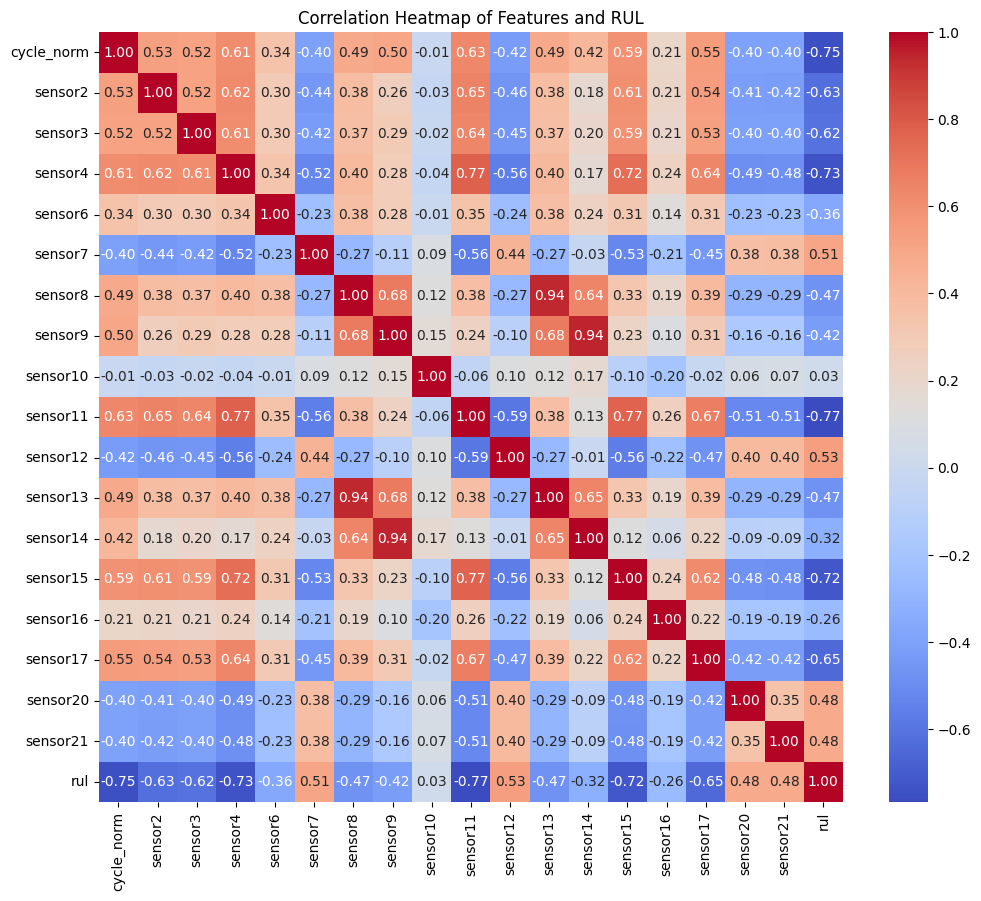

In [15]:
# Visualize correlations
corr = train_fd2[features + ['rul']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features and RUL')
plt.show()

## 3️⃣ Dataset - FD003

In [97]:
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
col_names = index_names + setting_names + sensor_names


train_fd3 = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/train_FD003.txt'), sep='\s+', header=None, names=col_names)
test_fd3 = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/test_FD003.txt'), sep='\s+', header=None, names=col_names)
RUL_fd3 = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/RUL_FD003.txt'), sep='\s+', header=None, names=['RUL'])

In [98]:
train_fd3.head()

engine  cycle  setting_1  setting_2  setting_3  \
0       1      1    -0.0005     0.0004      100.0   
1       1      2     0.0008    -0.0003      100.0   
2       1      3    -0.0014    -0.0002      100.0   
3       1      4    -0.0020     0.0001      100.0   
4       1      5     0.0016     0.0000      100.0   

   (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                        518.67                         642.36   
1                        518.67                         642.50   
2                        518.67                         642.18   
3                        518.67                         642.92   
4                        518.67                         641.68   

   (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                        1583.23                        1396.84   
1                        1584.69                        1396.89   
2                        1582.35                        1405.61   
3                        1585.61                        1392.27   
4                        1588.63                        1397.65   

   (Fan inlet Pressure) (psia)  ...  (Ratio of fuel flow to Ps30) (pps/psia)  \
0                        14.62  ...                                   522.31   
1                        14.62  ...                                   522.42   
2                        14.62  ...                                   522.03   
3                        14.62  ...                                   522.49   
4                        14.62  ...                                   522.58   

   (Corrected fan speed) (rpm)  (Corrected core speed) (rpm)  (Bypass Ratio)   \
0                      2388.01                       8145.32           8.4246   
1                      2388.03                       8152.85           8.4403   
2                      2388.00                       8150.17           8.3901   
3                      2388.08                       8146.56           8.3878   
4                      2388.03                       8147.80           8.3869   

   (Burner fuel-air ratio)  (Bleed Enthalpy)  (Required fan speed)  \
0                     0.03               391                  2388   
1                     0.03               392                  2388   
2                     0.03               391                  2388   
3                     0.03               392                  2388   
4                     0.03               392                  2388   

   (Required fan conversion speed)  (High-pressure turbines Cool air flow)  \
0                            100.0                                   39.11   
1                            100.0                                   38.99   
2                            100.0                                   38.85   
3                            100.0                                   38.96   
4                            100.0                                   39.14   

   (Low-pressure turbines Cool air flow)  
0                                23.3537  
1                                23.4491  
2                                23.3669  
3                                23.2951  
4                                23.4583  

[5 rows x 26 columns]

In [99]:
test_fd3.head()

engine  cycle  setting_1  setting_2  setting_3  \
0       1      1    -0.0017    -0.0004      100.0   
1       1      2     0.0006    -0.0002      100.0   
2       1      3     0.0014    -0.0003      100.0   
3       1      4     0.0027     0.0001      100.0   
4       1      5    -0.0001     0.0001      100.0   

   (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                        518.67                         641.94   
1                        518.67                         642.02   
2                        518.67                         641.68   
3                        518.67                         642.20   
4                        518.67                         642.46   

   (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                        1581.93                        1396.93   
1                        1584.86                        1398.90   
2                        1581.78                        1391.92   
3                        1584.53                        1395.34   
4                        1589.03                        1395.86   

   (Fan inlet Pressure) (psia)  ...  (Ratio of fuel flow to Ps30) (pps/psia)  \
0                        14.62  ...                                   521.89   
1                        14.62  ...                                   521.85   
2                        14.62  ...                                   522.10   
3                        14.62  ...                                   522.45   
4                        14.62  ...                                   521.91   

   (Corrected fan speed) (rpm)  (Corrected core speed) (rpm)  (Bypass Ratio)   \
0                      2387.94                       8133.48           8.3760   
1                      2388.01                       8137.44           8.4062   
2                      2387.94                       8138.25           8.3553   
3                      2387.96                       8137.07           8.3709   
4                      2387.97                       8134.20           8.4146   

   (Burner fuel-air ratio)  (Bleed Enthalpy)  (Required fan speed)  \
0                     0.03               391                  2388   
1                     0.03               391                  2388   
2                     0.03               391                  2388   
3                     0.03               392                  2388   
4                     0.03               391                  2388   

   (Required fan conversion speed)  (High-pressure turbines Cool air flow)  \
0                            100.0                                   39.07   
1                            100.0                                   39.04   
2                            100.0                                   39.10   
3                            100.0                                   38.97   
4                            100.0                                   39.09   

   (Low-pressure turbines Cool air flow)  
0                                23.4468  
1                                23.4807  
2                                23.4244  
3                                23.4782  
4                                23.3950  

[5 rows x 26 columns]

In [100]:
RUL_fd3.head()

RUL
0   44
1   51
2   27
3  120
4  101

In [20]:
train_fd3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24720 entries, 0 to 24719
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   engine                                   24720 non-null  int64  
 1   cycle                                    24720 non-null  int64  
 2   setting_1                                24720 non-null  float64
 3   setting_2                                24720 non-null  float64
 4   setting_3                                24720 non-null  float64
 5   (Fan inlet temperature) (◦R)             24720 non-null  float64
 6   (LPC outlet temperature) (◦R)            24720 non-null  float64
 7   (HPC outlet temperature) (◦R)            24720 non-null  float64
 8   (LPT outlet temperature) (◦R)            24720 non-null  float64
 9   (Fan inlet Pressure) (psia)              24720 non-null  float64
 10  (bypass-duct pressure) (psia)            24720

In [21]:
train_fd3.describe(include='all').T

count         mean           std  \
engine                                   24720.0    48.631877  2.934899e+01   
cycle                                    24720.0   139.077063  9.884668e+01   
setting_1                                24720.0    -0.000024  2.193545e-03   
setting_2                                24720.0     0.000005  2.940429e-04   
setting_3                                24720.0   100.000000  0.000000e+00   
(Fan inlet temperature) (◦R)             24720.0   518.670000  6.684921e-11   
(LPC outlet temperature) (◦R)            24720.0   642.457858  5.230311e-01   
(HPC outlet temperature) (◦R)            24720.0  1588.079175  6.810418e+00   
(LPT outlet temperature) (◦R)            24720.0  1404.471212  9.773178e+00   
(Fan inlet Pressure) (psia)              24720.0    14.620000  3.602525e-12   
(bypass-duct pressure) (psia)            24720.0    21.595841  1.811600e-02   
(HPC outlet pressure) (psia)             24720.0   555.143808  3.437343e+00   
(Physical fan speed) (rpm)               24720.0  2388.071555  1.582849e-01   
(Physical core speed) (rpm)              24720.0  9064.110809  1.998029e+01   
(Engine pressure ratio(P50/P2)           24720.0     1.301232  3.484849e-03   
(HPC outlet Static pressure) (psia)      24720.0    47.415707  3.000742e-01   
(Ratio of fuel flow to Ps30) (pps/psia)  24720.0   523.050873  3.255314e+00   
(Corrected fan speed) (rpm)              24720.0  2388.071643  1.581207e-01   
(Corrected core speed) (rpm)             24720.0  8144.202916  1.650412e+01   
(Bypass Ratio)                           24720.0     8.396176  6.051161e-02   
(Burner fuel-air ratio)                  24720.0     0.030000  1.750371e-14   
(Bleed Enthalpy)                         24720.0   392.566545  1.761459e+00   
(Required fan speed)                     24720.0  2388.000000  0.000000e+00   
(Required fan conversion speed)          24720.0   100.000000  0.000000e+00   
(High-pressure turbines Cool air flow)   24720.0    38.988552  2.488647e-01   
(Low-pressure turbines Cool air flow)    24720.0    23.393024  1.492338e-01   

                                               min        25%        50%  \
engine                                      1.0000    23.0000    47.0000   
cycle                                       1.0000    62.0000   124.0000   
setting_1                                  -0.0086    -0.0015    -0.0000   
setting_2                                  -0.0006    -0.0002    -0.0000   
setting_3                                 100.0000   100.0000   100.0000   
(Fan inlet temperature) (◦R)              518.6700   518.6700   518.6700   
(LPC outlet temperature) (◦R)             640.8400   642.0800   642.4000   
(HPC outlet temperature) (◦R)            1564.3000  1583.2800  1587.5200   
(LPT outlet temperature) (◦R)            1377.0600  1397.1875  1402.9100   
(Fan inlet Pressure) (psia)                14.6200    14.6200    14.6200   
(bypass-duct pressure) (psia)              21.4500    21.5800    21.6000   
(HPC outlet pressure) (psia)              549.6100   553.1100   554.0500   
(Physical fan speed) (rpm)               2386.9000  2388.0000  2388.0700   
(Physical core speed) (rpm)              9017.9800  9051.9200  9060.0100   
(Engine pressure ratio(P50/P2)              1.2900     1.3000     1.3000   
(HPC outlet Static pressure) (psia)        46.6900    47.1900    47.3600   
(Ratio of fuel flow to Ps30) (pps/psia)   517.7700   521.1500   521.9800   
(Corrected fan speed) (rpm)              2386.9300  2388.0100  2388.0700   
(Corrected core speed) (rpm)             8099.6800  8134.5100  8141.2000   
(Bypass Ratio)                              8.1563     8.3606     8.3983   
(Burner fuel-air ratio)                     0.0300     0.0300     0.0300   
(Bleed Enthalpy)                          388.0000   391.0000   392.0000   
(Required fan speed)                     2388.0000  2388.0000  2388.0000   
(Required fan conversion speed)           100.0000   100.0000   100.0000   
(High-pre

## Remove Constant Columns  
Identify and drop columns with only one unique value from training and test data.  


In [22]:
constant_cols = [col for col in train_fd3.columns if train_fd3[col].nunique() == 1]

print("Columns with constant values:", constant_cols)
train_fd3.drop(constant_cols, axis=1, inplace=True, errors='ignore')
test_fd3.drop(constant_cols, axis=1, inplace=True, errors='ignore')


Columns with constant values: ['setting_3', '(Fan inlet temperature) (◦R)', '(Fan inlet Pressure) (psia)', '(Burner fuel-air ratio)', '(Required fan speed)', '(Required fan conversion speed)']


## Compute Engine Lifetime  
Group training data by engine to find maximum cycle for each engine and store it as engine life.  


In [23]:
df_train_RUL = train_fd3.groupby(['engine']).agg({'cycle':'max'})
df_train_RUL.rename(columns={'cycle':'life'},inplace=True)
df_train_RUL.head()

life
engine      
1        259
2        253
3        222
4        272
5        213

## Merge Engine Lifetime  
Add engine life information to the training data by merging with lifetime table.  


In [24]:
train_fd3=train_fd3.merge(df_train_RUL,how='left',on=['engine'])

## Calculate Remaining Useful Life (RUL)  
Compute RUL as the difference between engine life and current cycle, remove life column, and cap RUL values at 125.  


In [25]:
train_fd3['RUL']=train_fd3['life']-train_fd3['cycle']
train_fd3.drop(['life'],axis=1,inplace=True)

train_fd3['RUL'] = train_fd3['RUL']. clip(upper=125)
train_fd3.head()

engine  cycle  setting_1  setting_2  (LPC outlet temperature) (◦R)  \
0       1      1    -0.0005     0.0004                         642.36   
1       1      2     0.0008    -0.0003                         642.50   
2       1      3    -0.0014    -0.0002                         642.18   
3       1      4    -0.0020     0.0001                         642.92   
4       1      5     0.0016     0.0000                         641.68   

   (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                        1583.23                        1396.84   
1                        1584.69                        1396.89   
2                        1582.35                        1405.61   
3                        1585.61                        1392.27   
4                        1588.63                        1397.65   

   (bypass-duct pressure) (psia)  (HPC outlet pressure) (psia)  \
0                          21.61                        553.97   
1                          21.61                        554.55   
2                          21.61                        554.43   
3                          21.61                        555.21   
4                          21.61                        554.74   

   (Physical fan speed) (rpm)  ...  (Engine pressure ratio(P50/P2)  \
0                     2387.96  ...                             1.3   
1                     2388.00  ...                             1.3   
2                     2388.03  ...                             1.3   
3                     2388.00  ...                             1.3   
4                     2388.04  ...                             1.3   

   (HPC outlet Static pressure) (psia)  \
0                                47.30   
1                                47.23   
2                                47.22   
3                                47.24   
4                                47.15   

   (Ratio of fuel flow to Ps30) (pps/psia)  (Corrected fan speed) (rpm)  \
0                                   522.31                      2388.01   
1                                   522.42                      2388.03   
2                                   522.03                      2388.00   
3                                   522.49                      2388.08   
4                                   522.58                      2388.03   

   (Corrected core speed) (rpm)  (Bypass Ratio)   (Bleed Enthalpy)  \
0                       8145.32           8.4246               391   
1                       8152.85           8.4403               392   
2                       8150.17           8.3901               391   
3                       8146.56           8.3878               392   
4                       8147.80           8.3869               392   

   (High-pressure turbines Cool air flow)  \
0                                   39.11   
1                                   38.99   
2                                   38.85   
3                                   38.96   
4                                   39.14   

   (Low-pressure turbines Cool air flow)  RUL  
0                                23.3537  125  
1                                23.4491  125  
2                                23.3669  125  
3                                23.2951  125  
4                                23.4583  125  

[5 rows x 21 columns]

In [101]:
Selected_Features = []
import statsmodels.api as sm

def backward_regression(X, y, initial_list=[], threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression 

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling 
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
X = train_fd3.iloc[:,1:-1]
y = train_fd3.iloc[:,-1]
backward_regression(X, y)

worst_feature : (bypass-duct pressure) (psia), 0.9840519931111545 
worst_feature : setting_2, 0.9360270469298753 
worst_feature : (Engine pressure ratio(P50/P2), 0.871337139837946 
worst_feature : setting_1, 0.6755495385207697 
worst_feature : (Corrected core speed) (rpm), 0.44060286659478864 
worst_feature : (Physical fan speed) (rpm), 0.12666617041322303 

Selected Features:
['cycle', 'setting_3', '(Fan inlet temperature) (◦R)', '(LPC outlet temperature) (◦R)', '(HPC outlet temperature) (◦R)', '(LPT outlet temperature) (◦R)', '(Fan inlet Pressure) (psia)', '(HPC outlet pressure) (psia)', '(Physical core speed) (rpm)', '(HPC outlet Static pressure) (psia)', '(Ratio of fuel flow to Ps30) (pps/psia)', '(Corrected fan speed) (rpm)', '(Bypass Ratio) ', '(Burner fuel-air ratio)', '(Bleed Enthalpy)', '(Required fan speed)', '(Required fan conversion speed)', '(High-pressure turbines Cool air flow)']


In [102]:
Selected_Features

[['cycle',
  'setting_3',
  '(Fan inlet temperature) (◦R)',
  '(LPC outlet temperature) (◦R)',
  '(HPC outlet temperature) (◦R)',
  '(LPT outlet temperature) (◦R)',
  '(Fan inlet Pressure) (psia)',
  '(HPC outlet pressure) (psia)',
  '(Physical core speed) (rpm)',
  '(HPC outlet Static pressure) (psia)',
  '(Ratio of fuel flow to Ps30) (pps/psia)',
  '(Corrected fan speed) (rpm)',
  '(Bypass Ratio) ',
  '(Burner fuel-air ratio)',
  '(Bleed Enthalpy)',
  '(Required fan speed)',
  '(Required fan conversion speed)',
  '(High-pressure turbines Cool air flow)']]

In [103]:
feature_names = Selected_Features[0]
np.shape(X)

(24720, 24)

In [105]:
df_test_cycle = test_fd3.groupby(['engine']).agg({'cycle':'max'})
df_test_cycle.rename(columns={'cycle':'life'},inplace=True)
df_test_max = test_fd3.merge(df_test_cycle,how='left',on=['engine'])
df_test_max = df_test_max[(df_test_max['cycle']==df_test_max['life'])]
df_test_max.drop(['life'],axis=1,inplace=True)
# df_test_max

In [122]:
X_train_fd3 = train_fd3[feature_names]
y_train_fd3 = train_fd3.iloc[:,-1]
X_test_fd3 = df_test_max[feature_names]
y_test_fd3 = RUL_fd3.iloc[:,-1]
X_train_fd3.shape , y_train_fd3.shape , X_test_fd3.shape , y_test_fd3.shape

((24720, 18), (24720,), (100, 18), (100,))

In [124]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train_fd3 = sc.fit_transform(X_train_fd3)
X_test_fd3 = sc.transform(X_test_fd3)

## Engine Lifetime Distribution

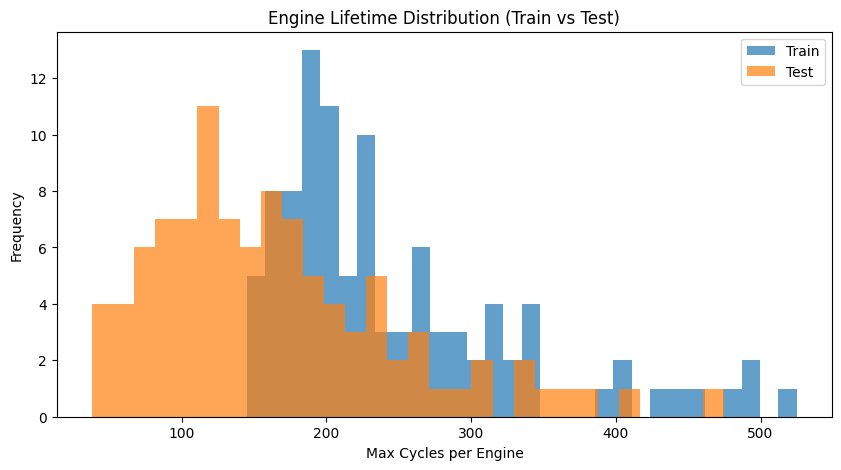

In [26]:
train_lifetimes = train_fd3.groupby("engine")["cycle"].max()
test_lifetimes = test_fd3.groupby("engine")["cycle"].max()

plt.figure(figsize=(10,5))
plt.hist(train_lifetimes, bins=30, alpha=0.7, label="Train")
plt.hist(test_lifetimes, bins=30, alpha=0.7, label="Test")
plt.xlabel("Max Cycles per Engine")
plt.ylabel("Frequency")
plt.title("Engine Lifetime Distribution (Train vs Test)")
plt.legend()
plt.show()

## Correlation Heatmap

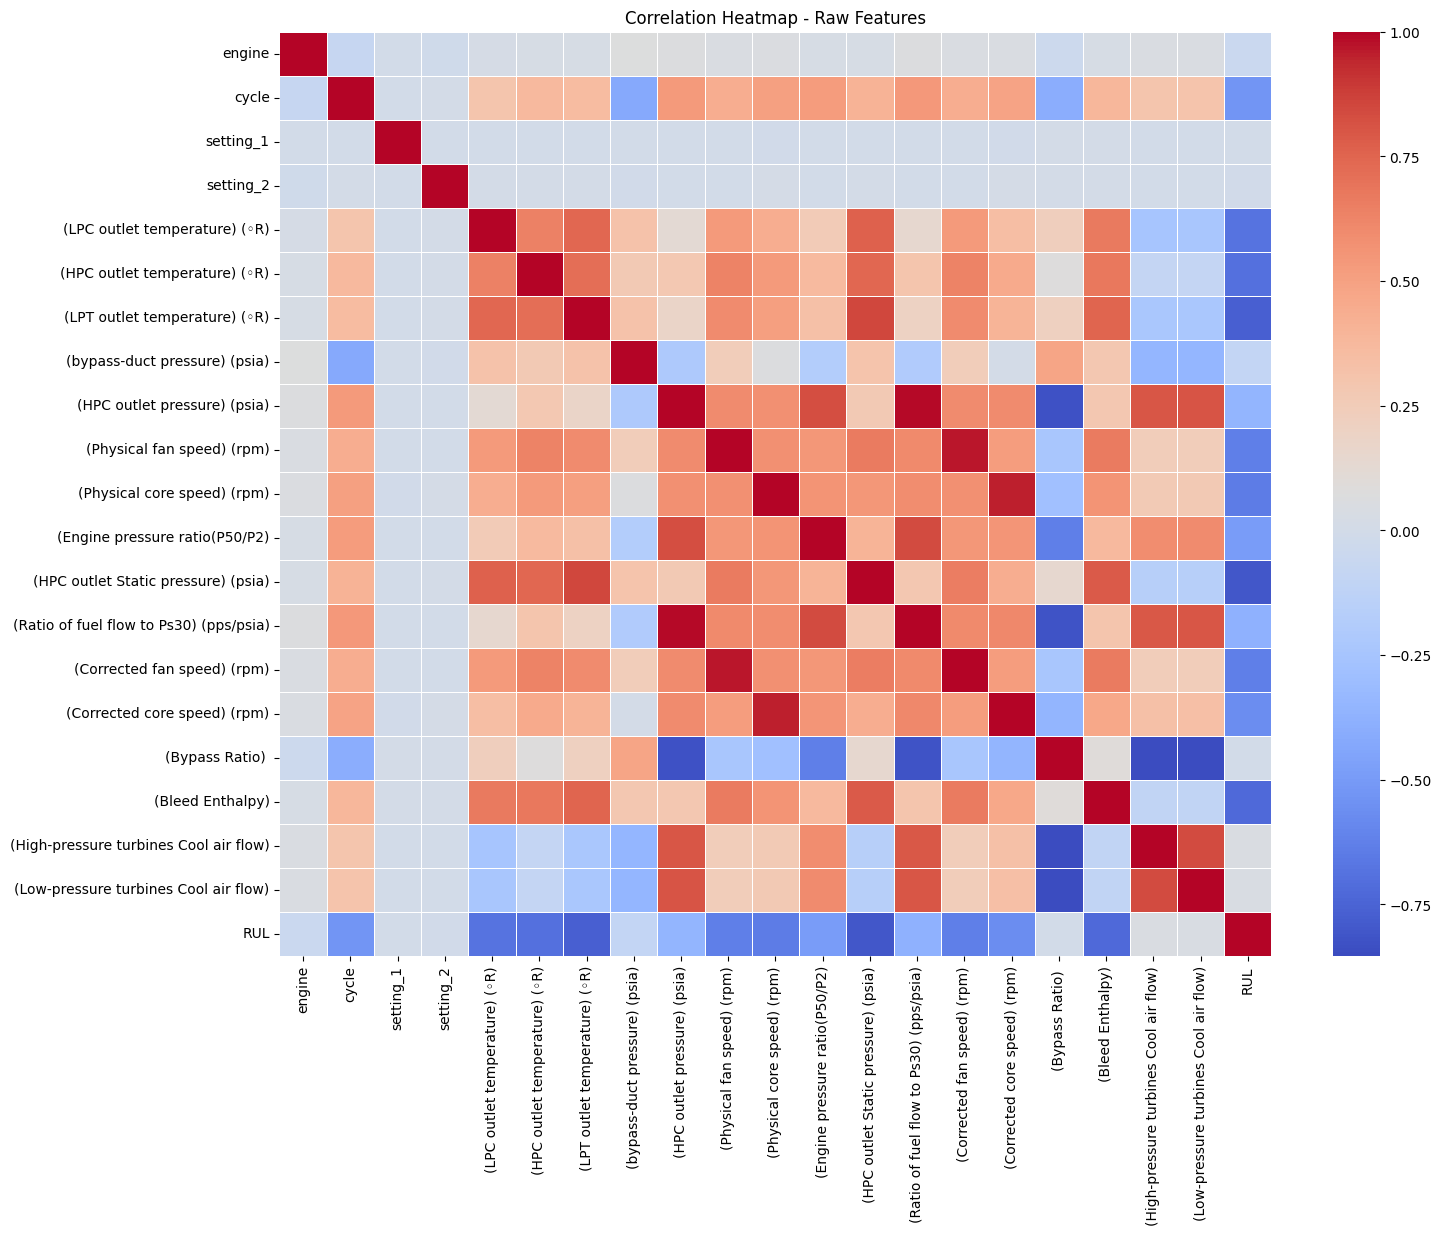

In [27]:
plt.figure(figsize=(16,12))
corr = train_fd3.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap - Raw Features")
plt.show()

## Sensor Distributions

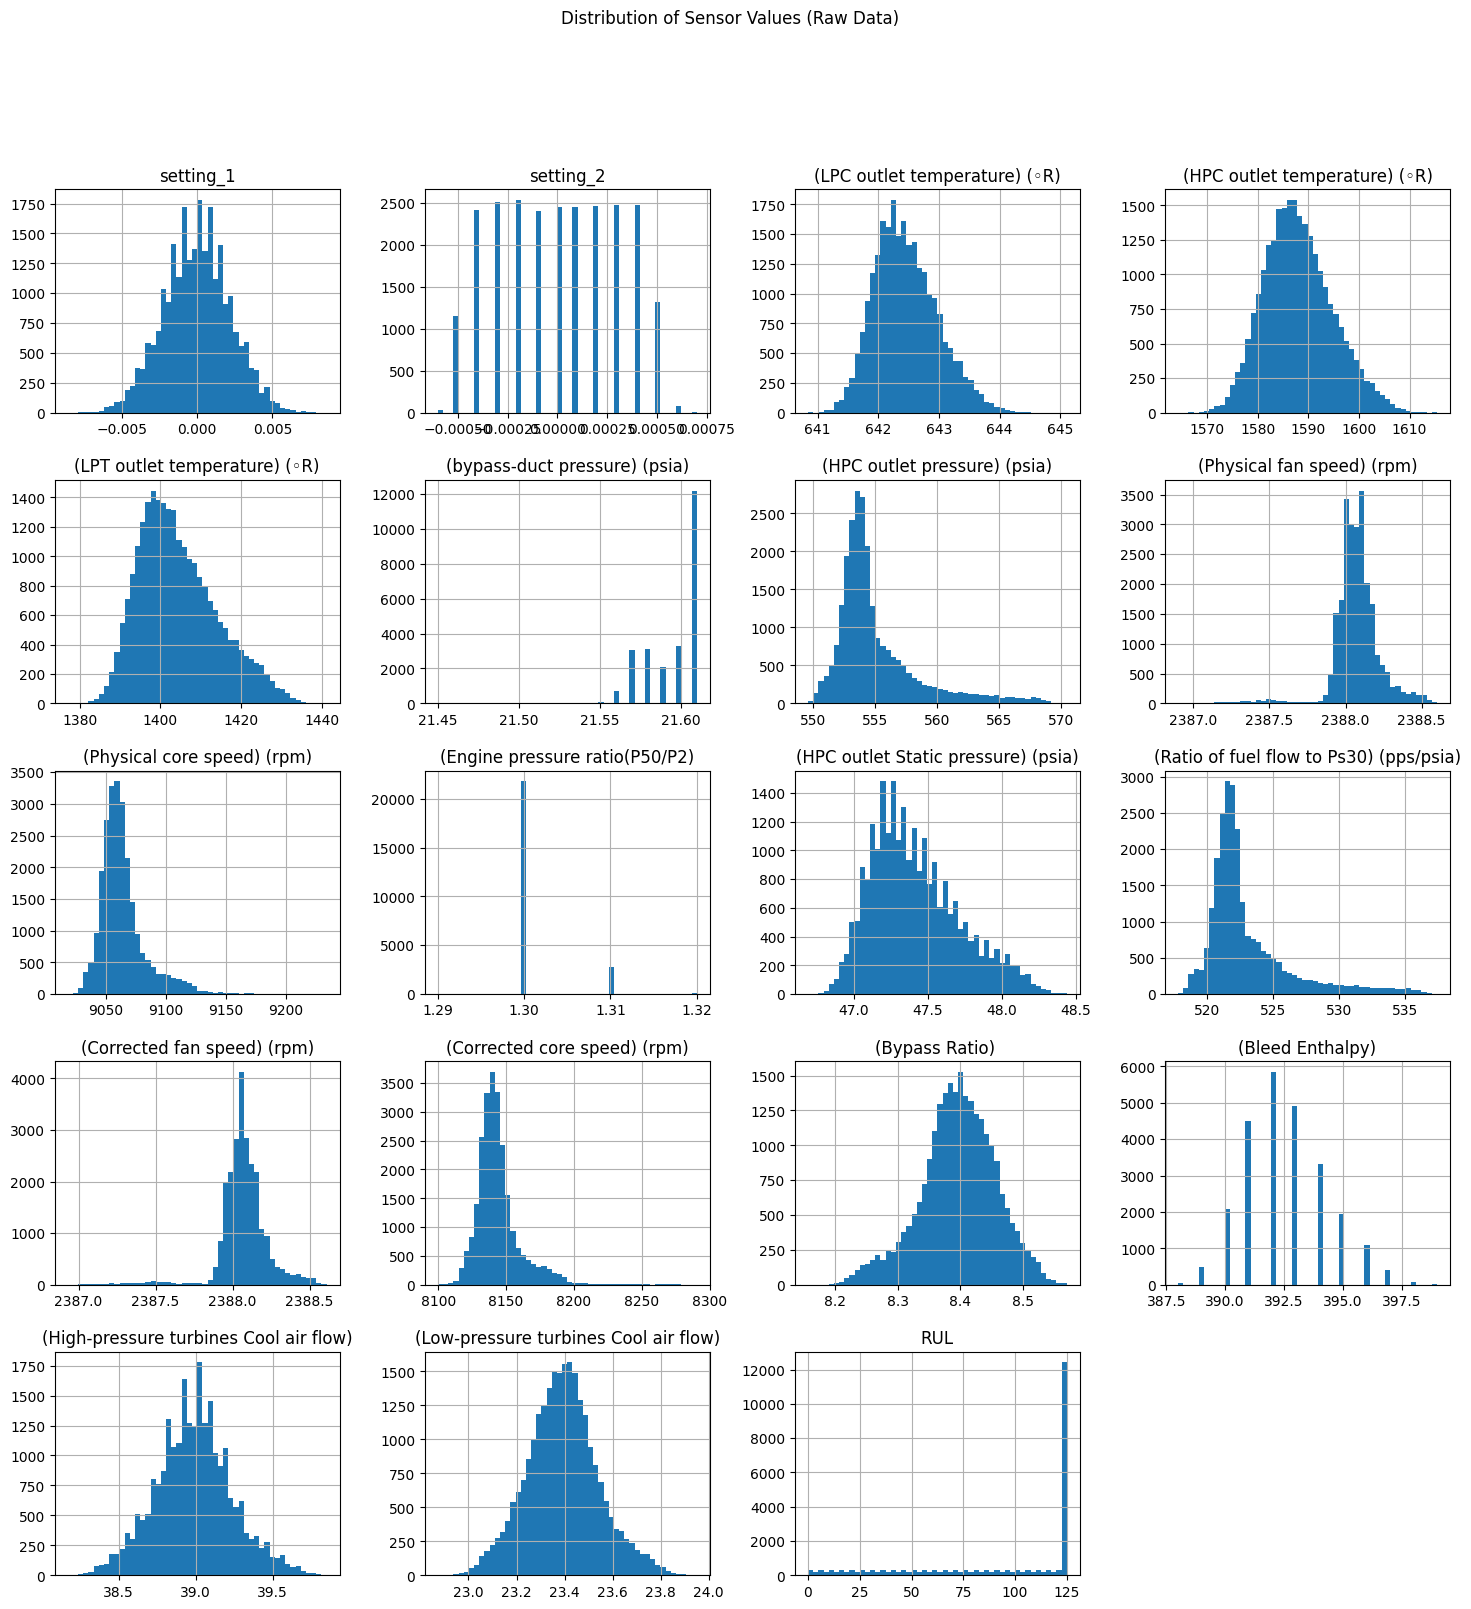

In [28]:
sensor_cols = [col for col in train_fd3.columns if col not in ['engine','cycle']]
train_fd3[sensor_cols].hist(figsize=(18,18), bins=50)
plt.suptitle("Distribution of Sensor Values (Raw Data)")
plt.show()

## Sensor Trends (Random Engines)

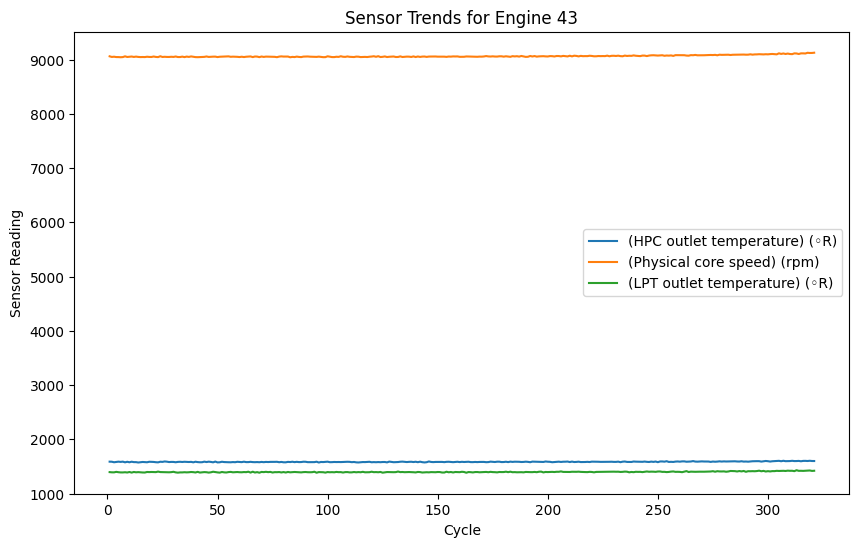

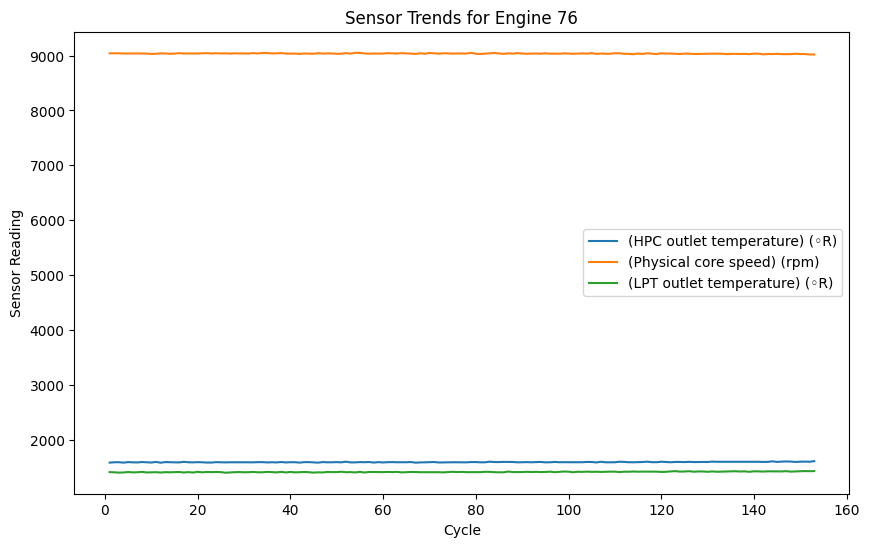

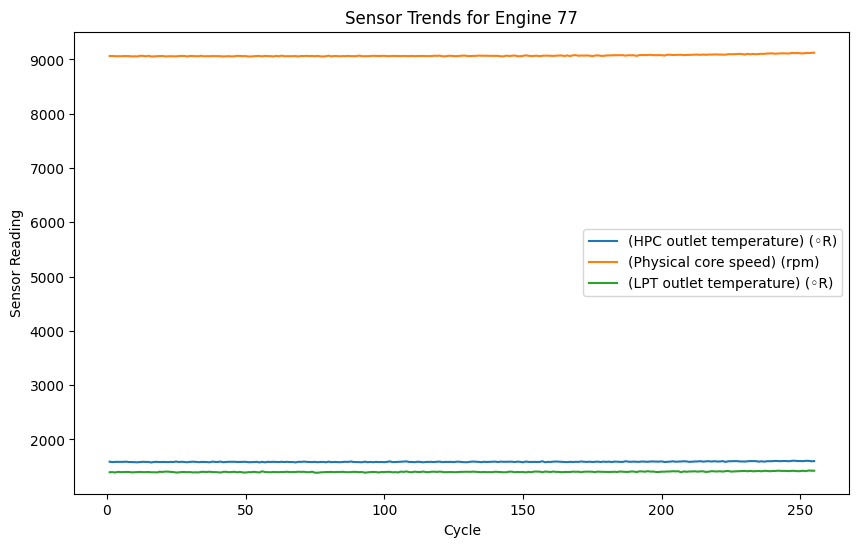

In [29]:
example_engines = random.sample(train_fd3['engine'].unique().tolist(), 3)
selected_sensors = [
    "(HPC outlet temperature) (◦R)",
    "(Physical core speed) (rpm)",
    "(LPT outlet temperature) (◦R)"
]

for eng in example_engines:
    subset = train_fd3[train_fd3['engine'] == eng]
    subset.plot(x="cycle", y=selected_sensors, figsize=(10,6))
    plt.title(f"Sensor Trends for Engine {eng}")
    plt.xlabel("Cycle")
    plt.ylabel("Sensor Reading")
    plt.show()

## Calculate RUL

In [30]:
train_fd3["max_cycle"] = train_fd3.groupby("engine")["cycle"].transform("max")
train_fd3["RUL"] = train_fd3["max_cycle"] - train_fd3["cycle"]
train_fd3[train_fd3["engine"] == 1].tail()

engine  cycle  setting_1  setting_2  (LPC outlet temperature) (◦R)  \
254       1    255     0.0050    -0.0004                         643.40   
255       1    256     0.0019     0.0001                         643.84   
256       1    257    -0.0032    -0.0002                         643.52   
257       1    258    -0.0005     0.0001                         643.66   
258       1    259     0.0043    -0.0001                         643.94   

     (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
254                        1599.87                        1427.90   
255                        1599.31                        1423.73   
256                        1601.37                        1425.25   
257                        1606.80                        1431.35   
258                        1599.54                        1434.33   

     (bypass-duct pressure) (psia)  (HPC outlet pressure) (psia)  \
254                          21.61                        552.09   
255                          21.61                        551.66   
256                          21.61                        551.44   
257                          21.61                        551.87   
258                          21.61                        551.60   

     (Physical fan speed) (rpm)  ...  (HPC outlet Static pressure) (psia)  \
254                     2388.28  ...                                48.24   
255                     2388.19  ...                                48.05   
256                     2388.28  ...                                48.16   
257                     2388.28  ...                                48.11   
258                     2388.25  ...                                48.34   

     (Ratio of fuel flow to Ps30) (pps/psia)  (Corrected fan speed) (rpm)  \
254                                   520.30                      2388.22   
255                                   519.89                      2388.22   
256                                   519.71                      2388.26   
257                                   519.72                      2388.21   
258                                   519.44                      2388.23   

     (Corrected core speed) (rpm)  (Bypass Ratio)   (Bleed Enthalpy)  \
254                       8143.28           8.5179               394   
255                       8151.14           8.5058               397   
256                       8149.36           8.5308               398   
257                       8150.92           8.4947               396   
258                       8149.15           8.5313               398   

     (High-pressure turbines Cool air flow)  \
254                                   38.39   
255                                   38.46   
256                                   38.36   
257                                   38.49   
258                                   38.35   

     (Low-pressure turbines Cool air flow)  RUL  max_cycle  
254                                23.0716    4        259  
255                                23.0488    3        259  
256                                23.1058    2        259  
257                                23.0658    1        259  
258                                23.0707    0        259  

[5 rows x 22 columns]

## RUL Visualization

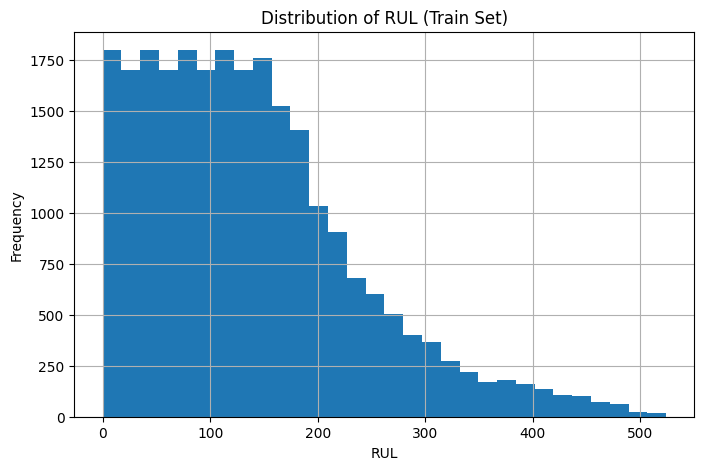

In [31]:
plt.figure(figsize=(8,5))
train_fd3["RUL"].hist(bins=30)
plt.title("Distribution of RUL (Train Set)")
plt.xlabel("RUL")
plt.ylabel("Frequency")
plt.show()

## Sensor VS RUL

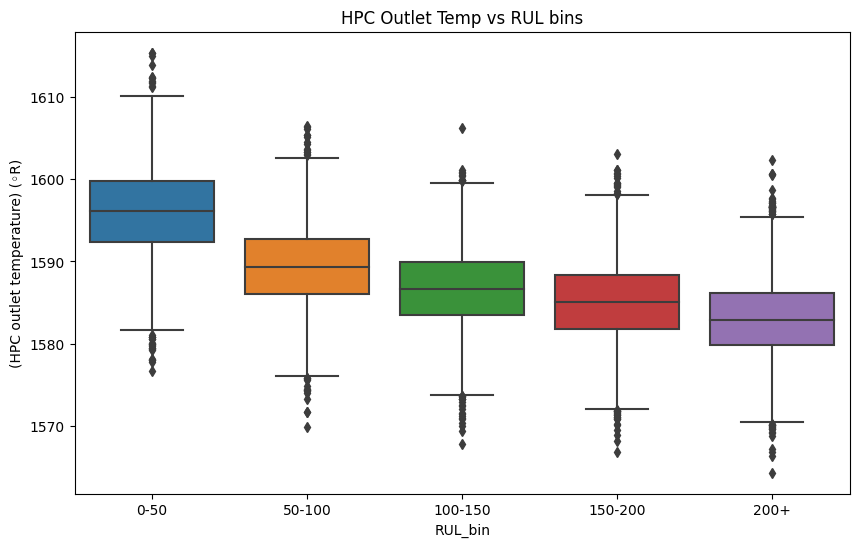

In [32]:
train_fd3["RUL_bin"] = pd.cut(train_fd3["RUL"], bins=[0,50,100,150,200,500], labels=["0-50","50-100","100-150","150-200","200+"])

plt.figure(figsize=(10,6))
sns.boxplot(x="RUL_bin", y="(HPC outlet temperature) (◦R)", data=train_fd3)
plt.title("HPC Outlet Temp vs RUL bins")
plt.show()

## Train VS Test (Distribution)

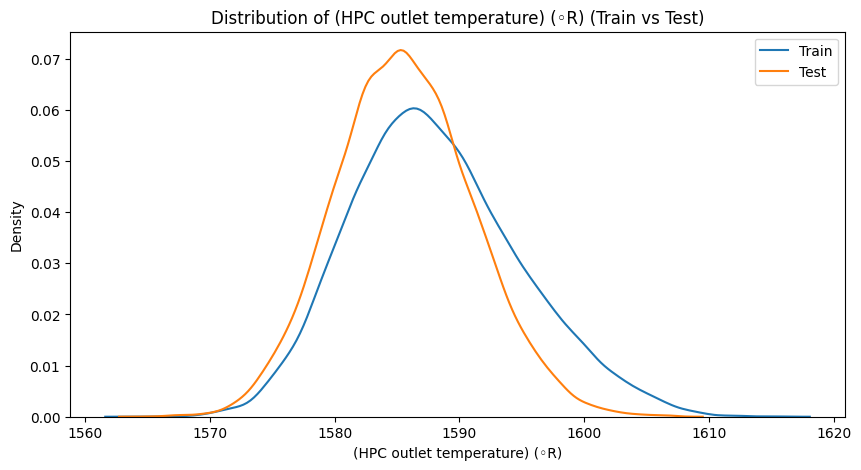

In [33]:
sensor = "(HPC outlet temperature) (◦R)"
plt.figure(figsize=(10,5))
sns.kdeplot(train_fd3[sensor], label="Train")
sns.kdeplot(test_fd3[sensor], label="Test")
plt.title(f"Distribution of {sensor} (Train vs Test)")
plt.legend()
plt.show()

## Visualize Sensor Data with PCA  
Scale numeric sensor features, reduce dimensions to 2 principal components, and plot a scatter visualization colored by RUL.  


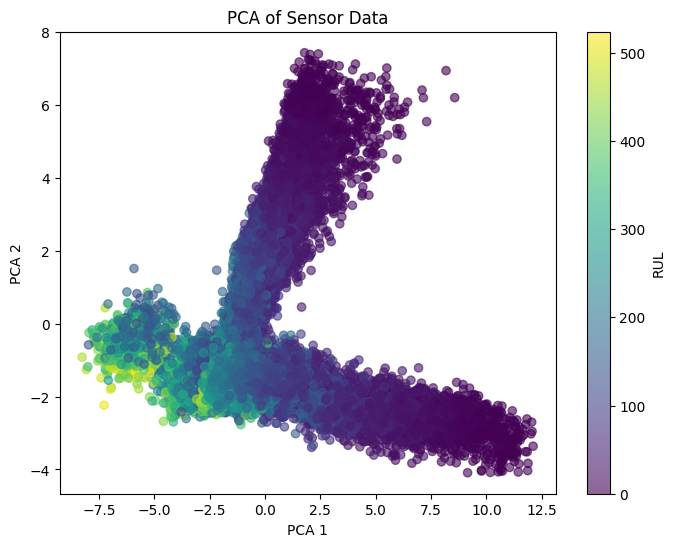

In [34]:
X = train_fd3[sensor_cols].select_dtypes(include=[np.number])
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1],
            c=train_fd3["RUL"], cmap="viridis", alpha=0.6)
plt.colorbar(label="RUL")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of Sensor Data")
plt.show()

## 4️⃣ Dataset - FD004

In [42]:
train_fd4 = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/train_FD004.txt'), sep=' ', header=None)
test_fd4 = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/test_FD004.txt'), sep=' ', header=None)
RUL_fd4 = pd.read_csv(('/kaggle/input/nasa-cmaps/CMaps/RUL_FD004.txt'), sep=' ', header=None)

In [43]:
train_fd4.drop(train_fd4.columns[[26, 27]], axis=1, inplace=True)
test_fd4.drop(test_fd4.columns[[26, 27]], axis=1, inplace=True)
RUL_fd4.drop(RUL_fd4.columns[[1]], axis=1, inplace=True)
print("df_train:" ,train_fd4.shape)
print("df_test:",test_fd4.shape)
print("rul:" ,RUL_fd4.shape)

df_train: (61249, 26)
df_test: (41214, 26)
rul: (248, 1)


In [44]:
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
col_names = index_names + setting_names + sensor_names
train_fd4.columns = col_names
test_fd4.columns = col_names
RUL_fd4.columns = ['RUL']

In [45]:
print(test_fd4.info())
print("---------------------------------")
print(train_fd4.info())
print("---------------------------------")
print(RUL_fd4.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41214 entries, 0 to 41213
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   engine                                   41214 non-null  int64  
 1   cycle                                    41214 non-null  int64  
 2   setting_1                                41214 non-null  float64
 3   setting_2                                41214 non-null  float64
 4   setting_3                                41214 non-null  float64
 5   (Fan inlet temperature) (◦R)             41214 non-null  float64
 6   (LPC outlet temperature) (◦R)            41214 non-null  float64
 7   (HPC outlet temperature) (◦R)            41214 non-null  float64
 8   (LPT outlet temperature) (◦R)            41214 non-null  float64
 9   (Fan inlet Pressure) (psia)              41214 non-null  float64
 10  (bypass-duct pressure) (psia)            41214

In [46]:
train_fd4.describe().transpose()

count         mean         std  \
engine                                   61249.0   124.325181   71.995350   
cycle                                    61249.0   134.311417   89.783389   
setting_1                                61249.0    23.999823   14.780722   
setting_2                                61249.0     0.571347    0.310703   
setting_3                                61249.0    94.031576   14.251954   
(Fan inlet temperature) (◦R)             61249.0   472.882435   26.436832   
(LPC outlet temperature) (◦R)            61249.0   579.420056   37.342647   
(HPC outlet temperature) (◦R)            61249.0  1417.896600  106.167598   
(LPT outlet temperature) (◦R)            61249.0  1201.915359  119.327591   
(Fan inlet Pressure) (psia)              61249.0     8.031626    3.622872   
(bypass-duct pressure) (psia)            61249.0    11.589457    5.444017   
(HPC outlet pressure) (psia)             61249.0   283.328633  146.880210   
(Physical fan speed) (rpm)               61249.0  2228.686034  145.348243   
(Physical core speed) (rpm)              61249.0  8524.673301  336.927547   
(Engine pressure ratio(P50/P2)           61249.0     1.096445    0.127681   
(HPC outlet Static pressure) (psia)      61249.0    42.874529    3.243492   
(Ratio of fuel flow to Ps30) (pps/psia)  61249.0   266.735665  138.479109   
(Corrected fan speed) (rpm)              61249.0  2334.427590  128.197859   
(Corrected core speed) (rpm)             61249.0  8067.811812   85.670543   
(Bypass Ratio)                           61249.0     9.285604    0.750374   
(Burner fuel-air ratio)                  61249.0     0.023252    0.004685   
(Bleed Enthalpy)                         61249.0   347.760029   27.808283   
(Required fan speed)                     61249.0  2228.613283  145.472491   
(Required fan conversion speed)          61249.0    97.751396    5.369424   
(High-pressure turbines Cool air flow)   61249.0    20.864333    9.936396   
(Low-pressure turbines Cool air flow)    61249.0    12.518995    5.962697   

                                               min        25%        50%  \
engine                                      1.0000    60.0000   126.0000   
cycle                                       1.0000    62.0000   123.0000   
setting_1                                   0.0000    10.0046    25.0014   
setting_2                                   0.0000     0.2507     0.7000   
setting_3                                  60.0000   100.0000   100.0000   
(Fan inlet temperature) (◦R)              445.0000   445.0000   462.5400   
(LPC outlet temperature) (◦R)             535.4800   549.3300   555.7400   
(HPC outlet temperature) (◦R)            1242.6700  1350.5500  1367.6800   
(LPT outlet temperature) (◦R)            1024.4200  1119.4900  1136.9200   
(Fan inlet Pressure) (psia)                 3.9100     3.9100     7.0500   
(bypass-duct pressure) (psia)               5.6700     5.7200     9.0300   
(HPC outlet pressure) (psia)              136.1700   142.9200   194.9600   
(Physical fan speed) (rpm)               1914.7200  2211.9500  2223.0700   
(Physical core speed) (rpm)              7984.5100  8320.5900  8362.7600   
(Engine pressure ratio(P50/P2)              0.9300     1.0200     1.0300   
(HPC outlet Static pressure) (psia)        36.0400    41.7600    42.3300   
(Ratio of fuel flow to Ps30) (pps/psia)   128.3100   134.5200   183.4500   
(Corrected fan speed) (rpm)              2027.5700  2387.9100  2388.0600   
(Corrected core speed) (rpm)             7845.7800  8062.6300  8083.8100   
(Bypass Ratio)                              8.1757     8.6480     9.2556   
(Burner fuel-air ratio)                     0.0200     0.0200     0.0200   
(Bleed Enthalpy)                          302.0000   330.0000   334.0000   
(Required fan speed)                     1915.0000  2212.0000  2223.0000   
(Required fan conversion speed)            84.9300   100.0000   100.0000   
(High-pressure turbines Cool air flow)     10.1600    10.9400  

In [47]:
train_fd4.duplicated().sum()

0

In [48]:
train_fd4.isnull().sum()

engine                                     0
cycle                                      0
setting_1                                  0
setting_2                                  0
setting_3                                  0
(Fan inlet temperature) (◦R)               0
(LPC outlet temperature) (◦R)              0
(HPC outlet temperature) (◦R)              0
(LPT outlet temperature) (◦R)              0
(Fan inlet Pressure) (psia)                0
(bypass-duct pressure) (psia)              0
(HPC outlet pressure) (psia)               0
(Physical fan speed) (rpm)                 0
(Physical core speed) (rpm)                0
(Engine pressure ratio(P50/P2)             0
(HPC outlet Static pressure) (psia)        0
(Ratio of fuel flow to Ps30) (pps/psia)    0
(Corrected fan speed) (rpm)                0
(Corrected core speed) (rpm)               0
(Bypass Ratio)                             0
(Burner fuel-air ratio)                    0
(Bleed Enthalpy)                           0
(Required 

## Feature engineering
Calculate RUL column.

In [49]:
max_cycles_df = train_fd4.groupby('engine')['cycle'].max().reset_index()
max_cycles_df.columns = ['engine', 'max_cycles']
max_cycles_df
train_fd4 = pd.merge(train_fd4, max_cycles_df, on='engine', how='left')

train_fd4['RUL'] = train_fd4['max_cycles'] - train_fd4['cycle']
train_fd4.drop(columns=['max_cycles'], inplace=True)
train_fd4

engine  cycle  setting_1  setting_2  setting_3  \
0           1      1    42.0049     0.8400      100.0   
1           1      2    20.0020     0.7002      100.0   
2           1      3    42.0038     0.8409      100.0   
3           1      4    42.0000     0.8400      100.0   
4           1      5    25.0063     0.6207       60.0   
...       ...    ...        ...        ...        ...   
61244     249    251     9.9998     0.2500      100.0   
61245     249    252     0.0028     0.0015      100.0   
61246     249    253     0.0029     0.0000      100.0   
61247     249    254    35.0046     0.8400      100.0   
61248     249    255    42.0030     0.8400      100.0   

       (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                            445.00                         549.68   
1                            491.19                         606.07   
2                            445.00                         548.95   
3                            445.00                         548.70   
4                            462.54                         536.10   
...                             ...                            ...   
61244                        489.05                         605.33   
61245                        518.67                         643.42   
61246                        518.67                         643.68   
61247                        449.44                         555.77   
61248                        445.00                         549.85   

       (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                            1343.43                        1112.93   
1                            1477.61                        1237.50   
2                            1343.12                        1117.05   
3                            1341.24                        1118.03   
4                            1255.23                        1033.59   
...                              ...                            ...   
61244                        1516.36                        1315.28   
61245                        1598.92                        1426.77   
61246                        1607.72                        1430.56   
61247                        1381.29                        1148.18   
61248                        1369.75                        1147.45   

       (Fan inlet Pressure) (psia)  ...  (Corrected fan speed) (rpm)  \
0                             3.91  ...                      2387.99   
1                             9.35  ...                      2387.73   
2                             3.91  ...                      2387.97   
3                             3.91  ...                      2388.02   
4                             7.05  ...                      2028.08   
...                            ...  ...                          ...   
61244                        10.52  ...                      2388.73   
61245                        14.62  ...                      2388.46   
61246                        14.62  ...                      2388.48   
61247                         5.48  ...                      2388.83   
61248                         3.91  ...                      2388.66   

       (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  \
0                           8074.83           9.3335                     0.02   
1                           8046.13           9.1913                     0.02   
2                           8066.62           9.4007                     0.02   
3                           8076.05           9.3369                     0.02   
4                           7865.80          10.8366                     0.02   
...                             ...              ...                      ...   
61244                       8185.69           8.4541                     0.03   
61245                       8185.47           8.2221                     0.03   
61246                       8193.9

**Then**, Scale a copy of the train dataframe for visualization using MinMaxscaler().

In [50]:
scaler = MinMaxScaler()

df_copy= train_fd4.copy()
feature_cols = df_copy.columns.drop(['engine', 'cycle','RUL']).tolist()

df_copy[feature_cols] = scaler.fit_transform(df_copy[feature_cols])

df_copy

engine  cycle  setting_1  setting_2  setting_3  \
0           1      1   0.999926   0.997625        1.0   
1           1      2   0.476147   0.831591        1.0   
2           1      3   0.999900   0.998694        1.0   
3           1      4   0.999810   0.997625        1.0   
4           1      5   0.595275   0.737173        0.0   
...       ...    ...        ...        ...        ...   
61244     249    251   0.238045   0.296912        1.0   
61245     249    252   0.000067   0.001781        1.0   
61246     249    253   0.000069   0.000000        1.0   
61247     249    254   0.833284   0.997625        1.0   
61248     249    255   0.999881   0.997625        1.0   

       (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                          0.000000                       0.130347   
1                          0.626985                       0.647971   
2                          0.000000                       0.123646   
3                          0.000000                       0.121351   
4                          0.238089                       0.005691   
...                             ...                            ...   
61244                      0.597937                       0.641179   
61245                      1.000000                       0.990821   
61246                      1.000000                       0.993207   
61247                      0.060269                       0.186249   
61248                      0.000000                       0.131907   

       (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                           0.272082                       0.212586   
1                           0.634407                       0.511781   
2                           0.271245                       0.222481   
3                           0.266168                       0.224835   
4                           0.033916                       0.022025   
...                              ...                            ...   
61244                       0.739044                       0.698595   
61245                       0.961980                       0.966374   
61246                       0.985742                       0.975477   
61247                       0.374315                       0.297250   
61248                       0.343153                       0.295497   

       (Fan inlet Pressure) (psia)  ...  (Corrected fan speed) (rpm)  \
0                         0.000000  ...                     0.993111   
1                         0.507937  ...                     0.992395   
2                         0.000000  ...                     0.993056   
3                         0.000000  ...                     0.993194   
4                         0.293184  ...                     0.001405   
...                            ...  ...                          ...   
61244                     0.617180  ...                     0.995150   
61245                     1.000000  ...                     0.994406   
61246                     1.000000  ...                     0.994462   
61247                     0.146592  ...                     0.995426   
61248                     0.000000  ...                     0.994958   

       (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  \
0                          0.550773         0.400540                      0.0   
1                          0.481761         0.351346                      0.0   
2                          0.531031         0.423787                      0.0   
3                          0.553707         0.401716                      0.0   
4                          0.048140         0.920536                      0.0   
...                             ...              ...                      ...   
61244                      0.817347         0.096312                      1.0   
61245                      0.816818         0.016052                      1.0   
61246                      0.83718

## Visualize Sensor Trends for Engine 1  
Plot time-series of selected sensor readings across cycles for engine ID 1 to observe variations and trends over time.  


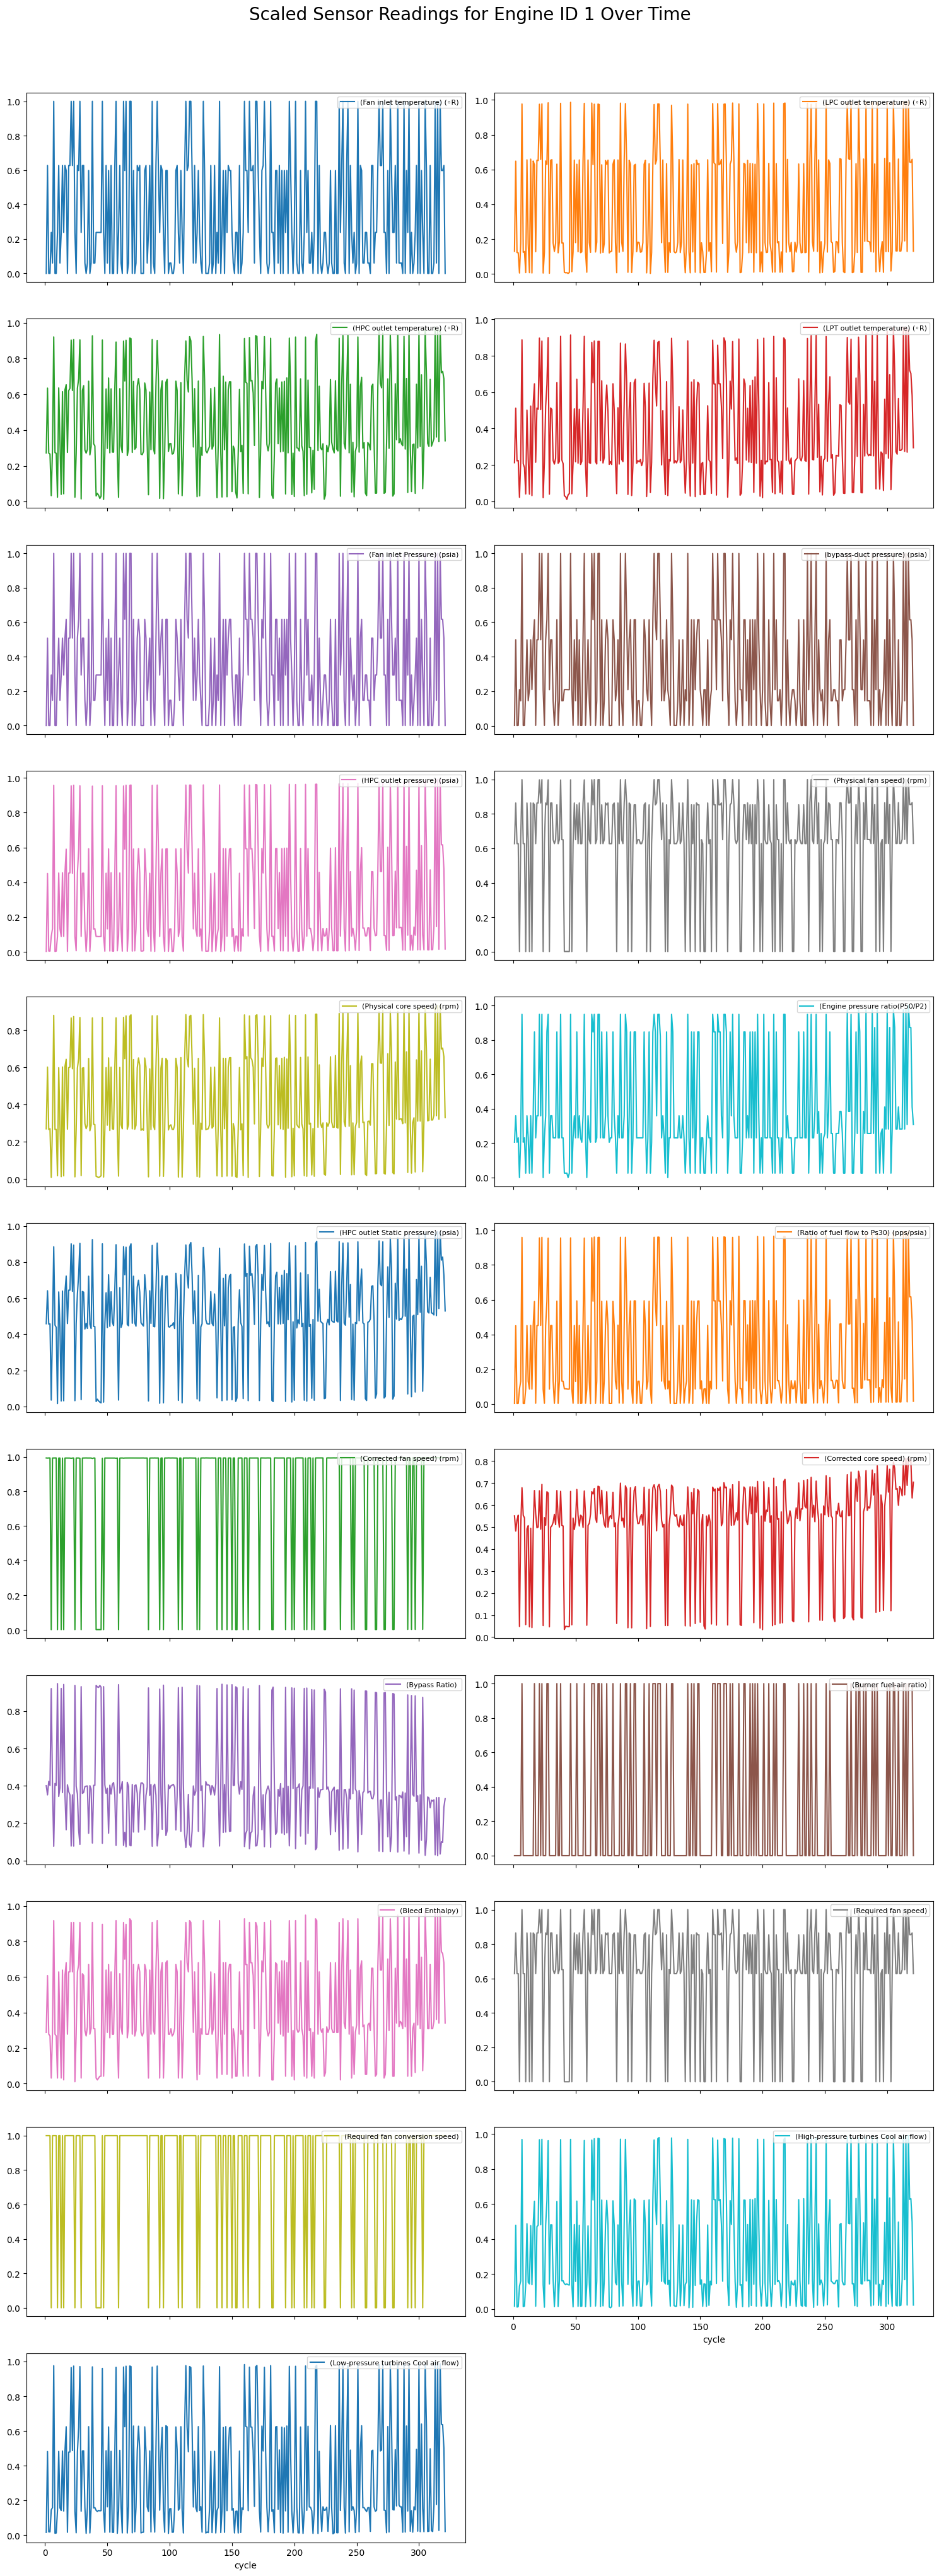

In [51]:

engine_to_plot = df_copy[df_copy['engine'] == 1]

sensors_to_plot = [ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
axes = engine_to_plot.plot(
    x='cycle', 
    y=sensors_to_plot, 
    subplots=True, 
    layout=(11, 2), 
    figsize=(15, 40), 
    legend=False)
plt.suptitle('Scaled Sensor Readings for Engine ID 1 Over Time', fontsize=20, y=1.02)

for ax, sensor in zip(axes.flatten(), sensors_to_plot):
    ax.legend([sensor], loc='upper right', fontsize=8)   

plt.tight_layout()
plt.show()

## Visualize Sensor Trends for Engine 10  
Plot time-series of selected sensor readings across cycles for engine ID 10 to analyze patterns and compare with other engines.  


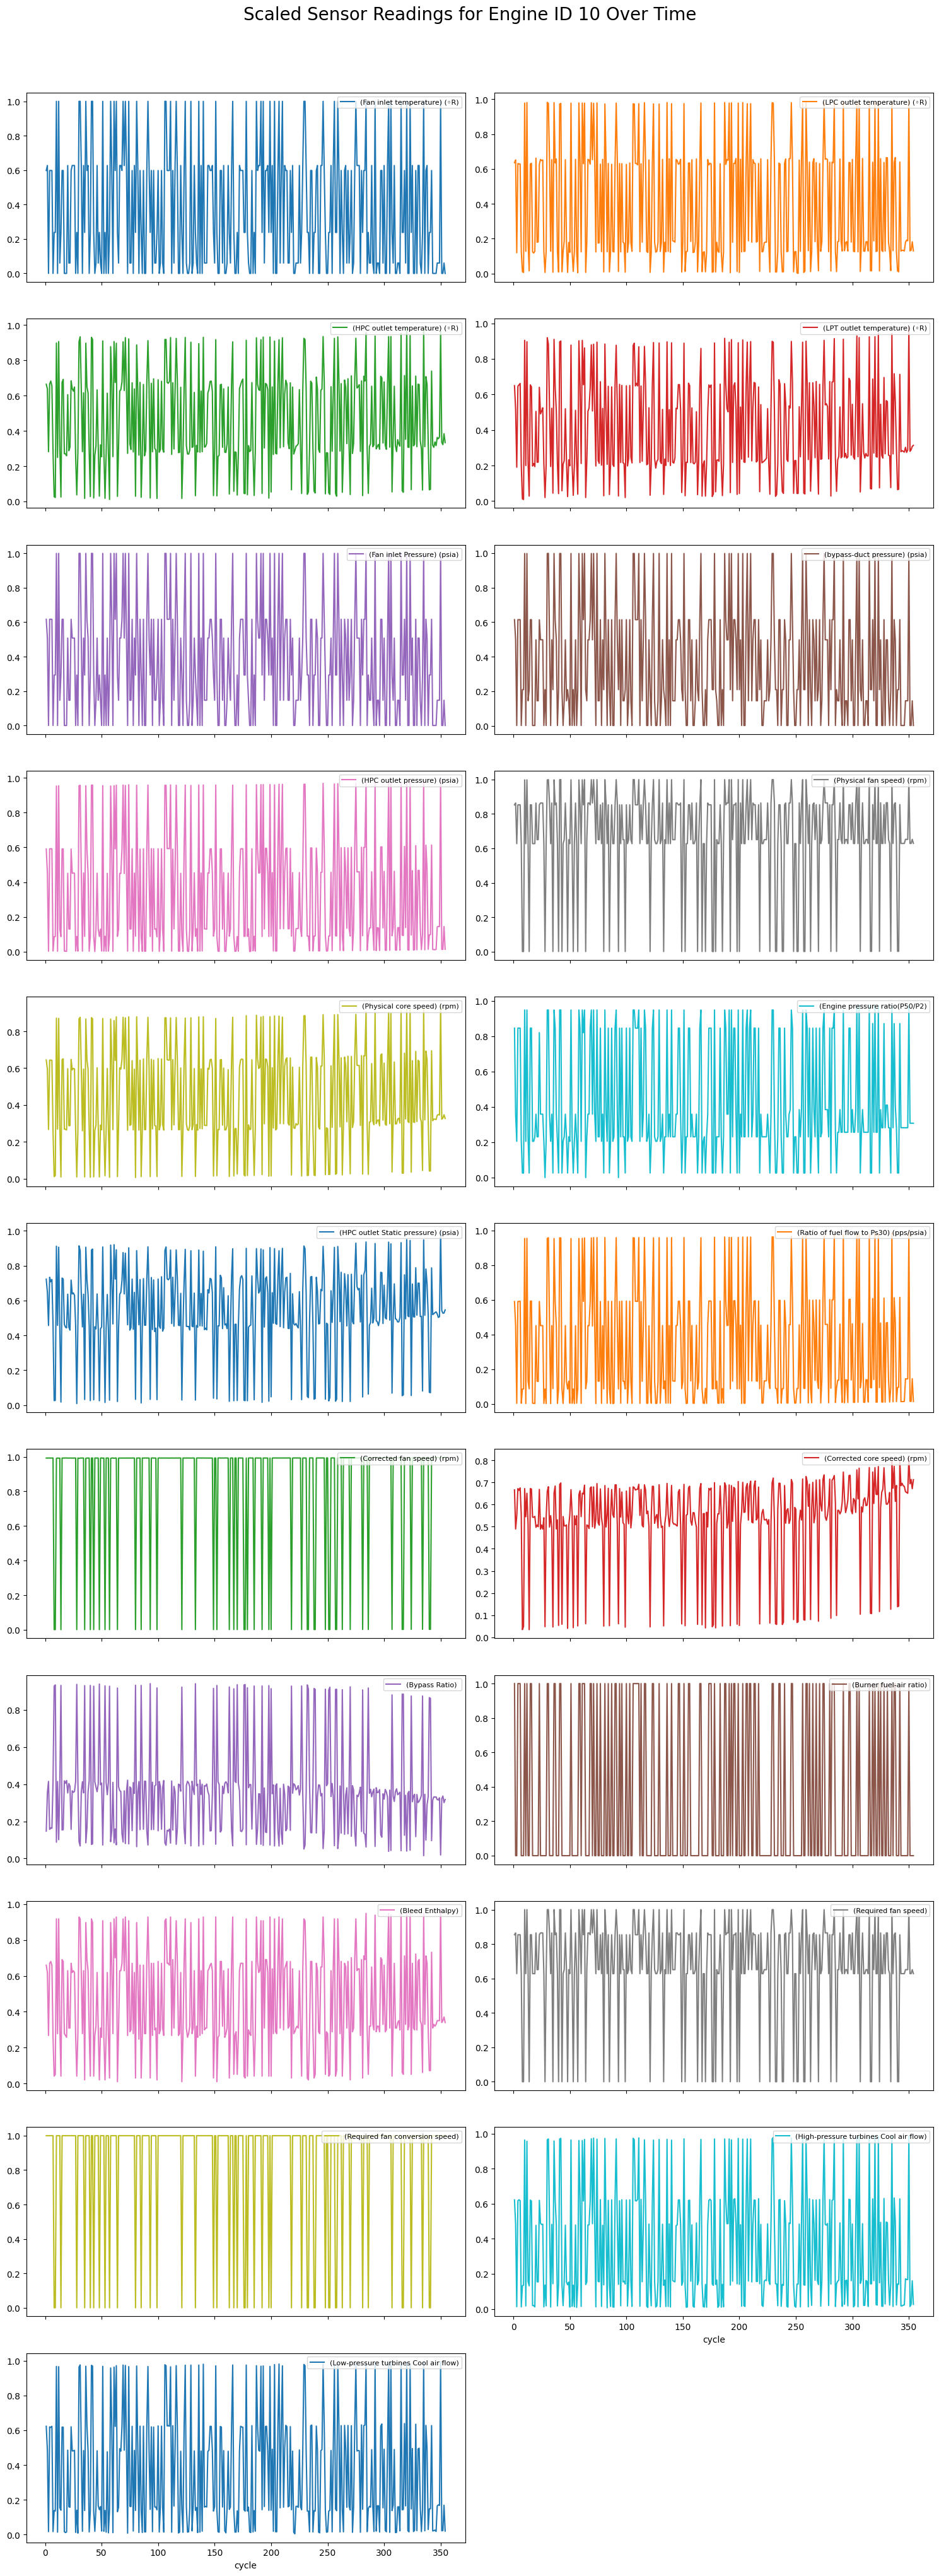

In [52]:
engine_to_plot = df_copy[df_copy['engine'] == 10]

sensors_to_plot = [ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
axes = engine_to_plot.plot(
    x='cycle', 
    y=sensors_to_plot, 
    subplots=True, 
    layout=(11, 2), 
    figsize=(15, 40), 
    legend=False)
plt.suptitle('Scaled Sensor Readings for Engine ID 10 Over Time', fontsize=20, y=1.02)

for ax, sensor in zip(axes.flatten(), sensors_to_plot):
    ax.legend([sensor], loc='upper right', fontsize=8)   

plt.tight_layout()
plt.show()

## Smooth Sensor Trends for Engine 1  
Apply rolling mean with a window of 10 cycles to smooth sensor readings for engine 1 and plot time-series trends for each sensor.  


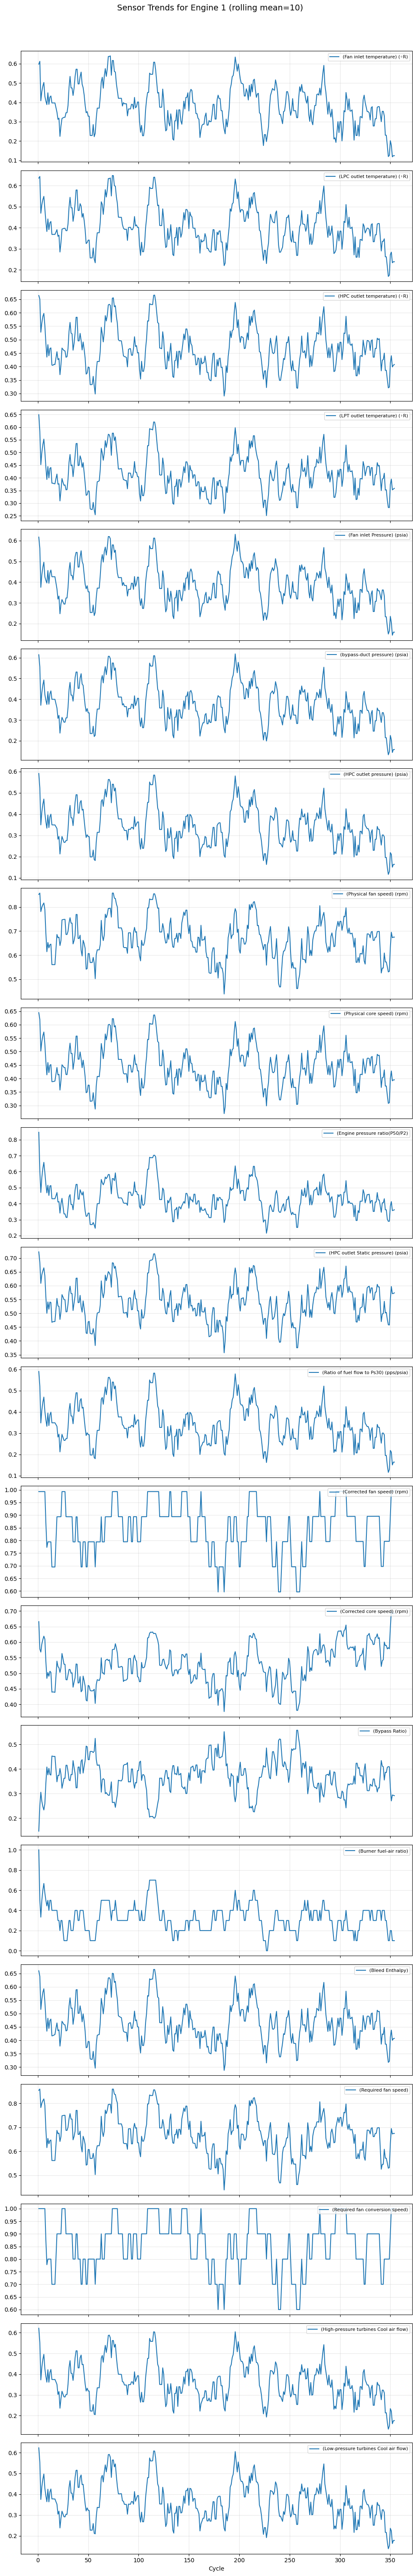

In [53]:
engine1_roll = engine_to_plot.copy()
engine1_roll[sensors_to_plot] = engine_to_plot[sensors_to_plot].rolling(window=10, min_periods=1).mean() 

n_sensors = len(sensors_to_plot)

fig, axes = plt.subplots(n_sensors, 1, figsize=(10, 3*n_sensors), sharex=True)

for ax, sensor in zip(axes, sensors_to_plot):
    ax.plot(engine1_roll['cycle'], engine1_roll[sensor], label=sensor)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

fig.suptitle("Sensor Trends for Engine 1 (rolling mean=10)", fontsize=14)

fig.subplots_adjust(top=0.96)  
plt.xlabel("Cycle")
plt.tight_layout(rect=[0, 0, 1, 0.97])  
plt.show()

## Smoothed Sensor Trends for Engine 10  
Create a copy of engine 10 data, apply rolling mean with a window of 10 cycles to smooth sensor readings, and plot time-series trends for all sensors to better observe gradual patterns and anomalies.  


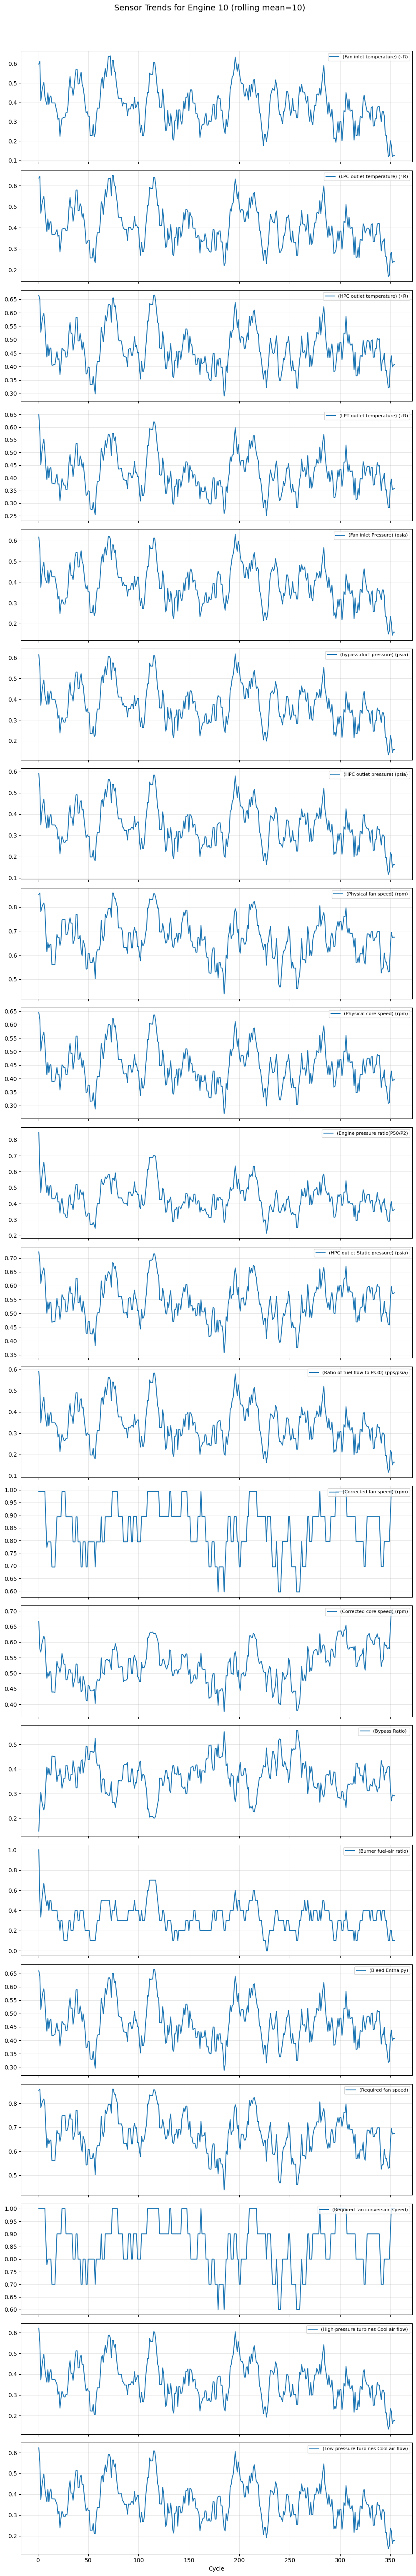

In [54]:
engine10 = df_copy[df_copy['engine']==10] 
engine10_roll= engine10.copy()
engine10_roll[sensors_to_plot] = engine10_roll[sensors_to_plot].rolling(window=10, min_periods=1).mean()

n_sensors = len(sensors_to_plot)

fig, axes = plt.subplots(n_sensors, 1, figsize=(10, 3*n_sensors), sharex=True)

for ax, sensor in zip(axes, sensors_to_plot):
    ax.plot(engine10_roll['cycle'], engine10_roll[sensor], label=sensor)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

fig.suptitle("Sensor Trends for Engine 10 (rolling mean=10)", fontsize=14)

fig.subplots_adjust(top=0.96)  
plt.xlabel("Cycle")
plt.tight_layout(rect=[0, 0, 1, 0.97])  
plt.show()

## Sensor Data Visualization and Smoothing  
Raw scaled sensor readings over engine cycles were first plotted, showing strong fluctuations and noise. To reveal clearer patterns, a rolling mean (window=10) was applied, smoothing the signals and highlighting underlying trends. This approach makes it easier to observe gradual degradation, stable behaviors, or sudden shifts in sensor values, which may indicate wear, operational changes, or early fault signs.  


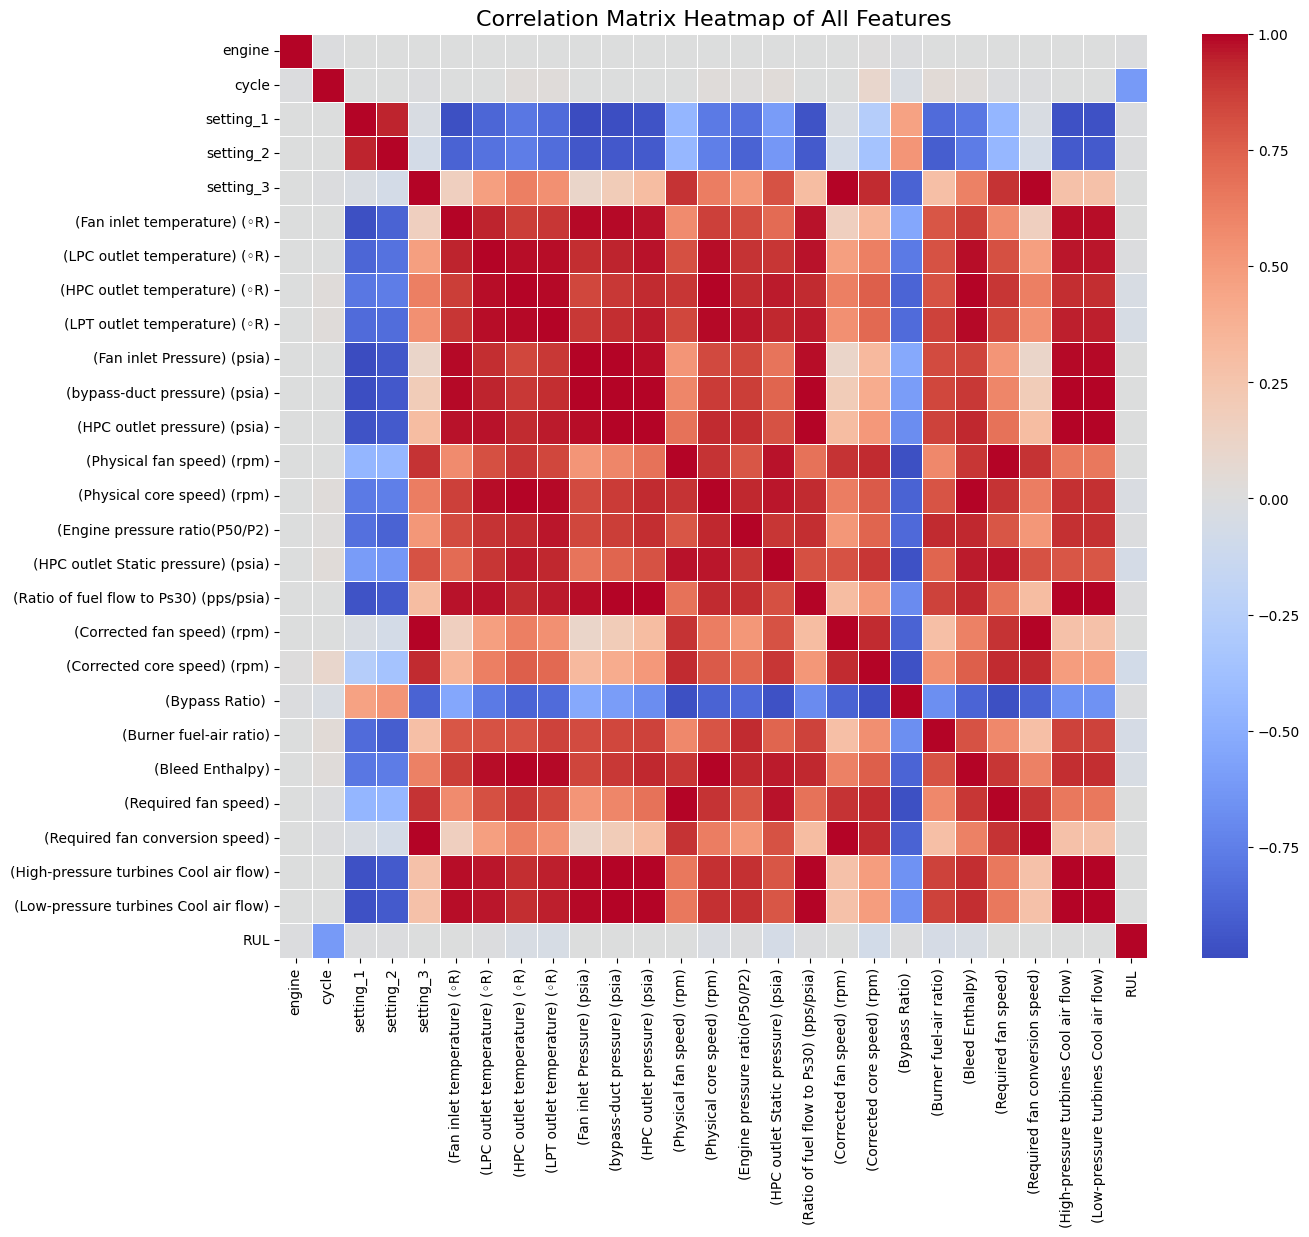

In [55]:
corr_matrix = df_copy.corr()

plt.figure(figsize=(14, 12))

sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)

plt.title('Correlation Matrix Heatmap of All Features', fontsize=16)
plt.show()

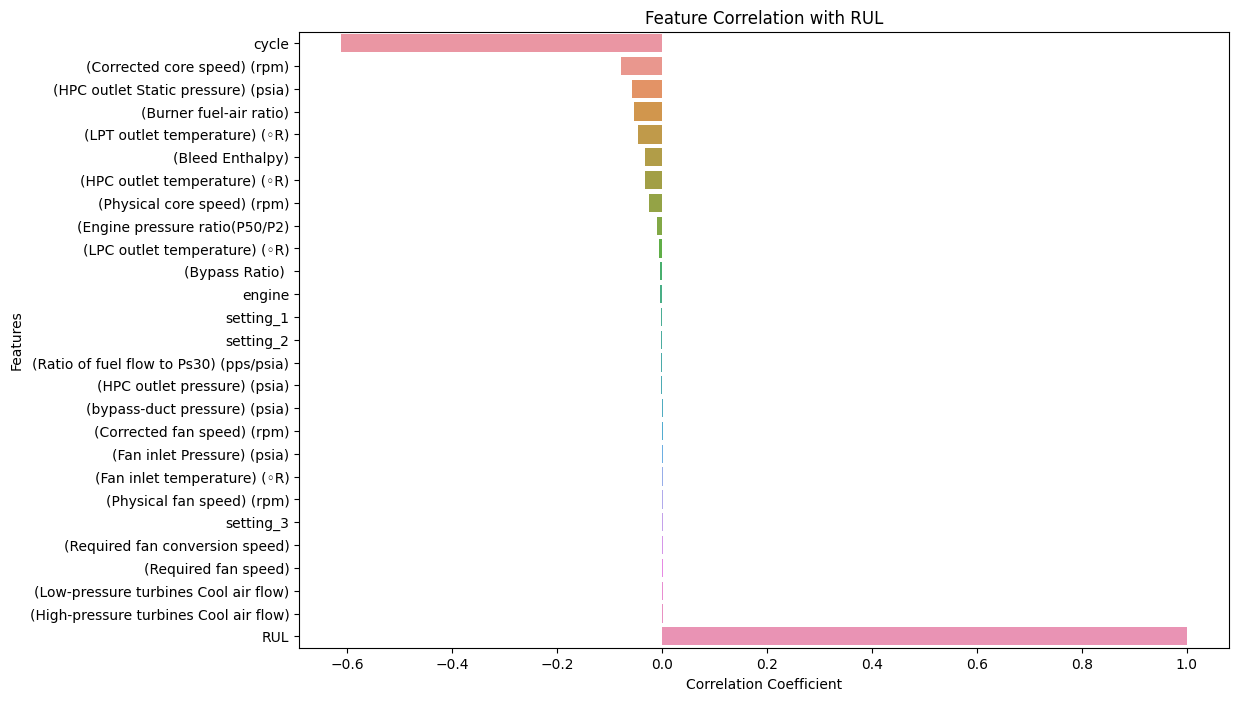

In [56]:
rul_correlations = corr_matrix['RUL'].sort_values(ascending=True)

plt.figure(figsize=(12, 8))

# Plot the correlations
sns.barplot(x=rul_correlations.values, y=rul_correlations.index)
plt.title('Feature Correlation with RUL')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

- The correlation heatmap shows strong positive correlation inside clear sensor groups (temperatures, pressures, speeds) — many sensors move together.

- A small set of features shows negative correlation with others (visible as blue bands), indicating different physical behavior or control settings.

- The RUL column displays noticeable correlation with a subset of sensors — some sensors trend together with remaining useful life.

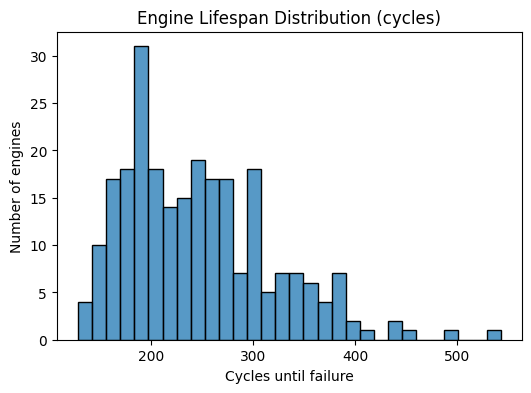

In [57]:
engine_cycles = df_copy.groupby('engine')['cycle'].max()  
plt.figure(figsize=(6,4))
sns.histplot(engine_cycles, bins=30, kde=False)   
plt.title("Engine Lifespan Distribution (cycles)")
plt.xlabel("Cycles until failure")
plt.ylabel("Number of engines")
plt.show()

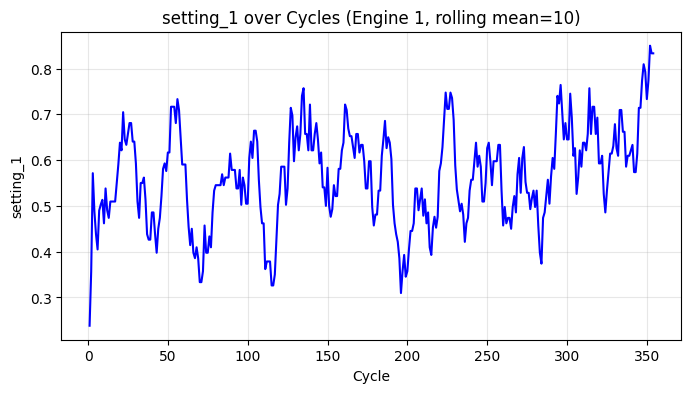

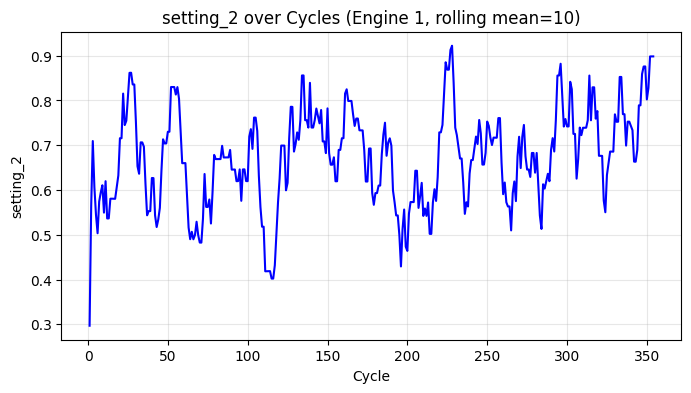

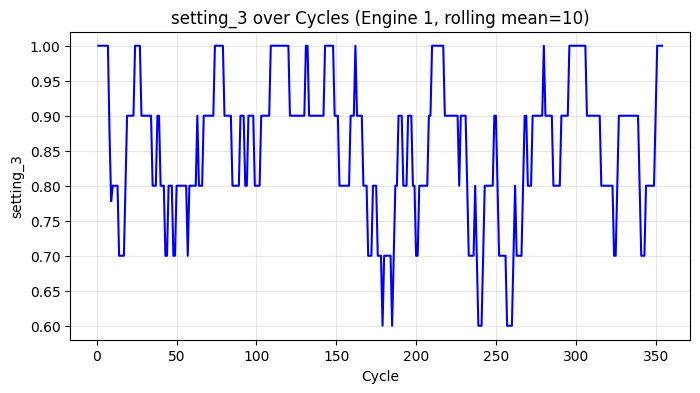

In [58]:
engine1_roll = engine_to_plot.copy()
for col in ['setting_1','setting_2','setting_3']:
    engine1_roll[col] = engine_to_plot[col].rolling(window=10, min_periods=1).mean()  

for col in ['setting_1','setting_2','setting_3']:
    plt.figure(figsize=(8,4))
    plt.plot(engine_to_plot['cycle'], engine1_roll[col], color='blue')
    plt.title(f"{col} over Cycles (Engine 1, rolling mean=10)")
    plt.xlabel("Cycle")
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)
    plt.show()

Settings 1 and 2 provide more informative degradation signals as they decrease with engine cycles, making them potentially useful predictors for RUL estimation. Setting 3 is less directly correlated with time, but may still add value in combination with other sensors.

In [59]:
RUL_CLIP_VALUE = 125

df_copy['RUL'] = df_copy['RUL'].clip(upper=RUL_CLIP_VALUE)

print(f"RUL values have been clipped at a maximum of {RUL_CLIP_VALUE}.")

RUL values have been clipped at a maximum of 125.


## Visualize Effect of RUL Clipping for Engine 1  
Compare original linear RUL with clipped RUL (at threshold value) across cycles for engine ID 1 to show how clipping modifies the degradation curve.  


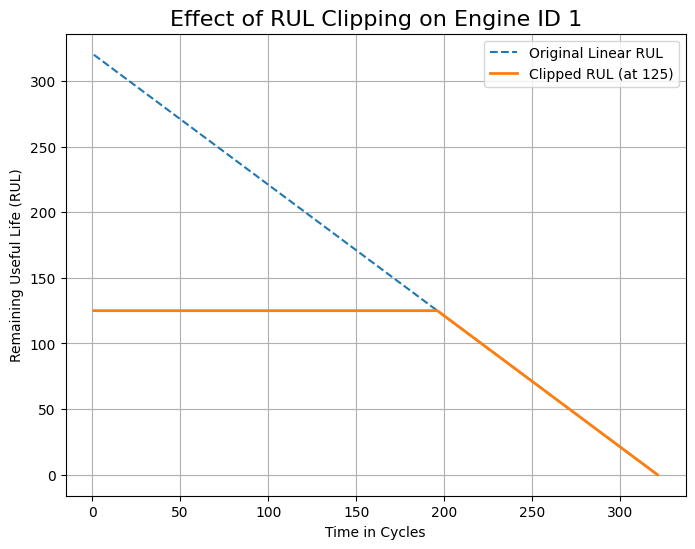

In [60]:
engine_to_plott = df_copy[df_copy['engine'] == 1].copy()
max_cycles_engine_1 = engine_to_plott['cycle'].max()
original_rul = max_cycles_engine_1 - engine_to_plott['cycle']


plt.figure(figsize=(8, 6))
plt.plot(engine_to_plott['cycle'], original_rul, label='Original Linear RUL', linestyle='--')
plt.plot(engine_to_plott['cycle'], engine_to_plott['RUL'], label=f'Clipped RUL (at {RUL_CLIP_VALUE})', linewidth=2)

plt.title('Effect of RUL Clipping on Engine ID 1', fontsize=16)
plt.xlabel('Time in Cycles')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.grid(True)
plt.show()

# **Phase 3**
## Model Training & Validation

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler 
import xgboost as xgb
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras import layers, models
from catboost import CatBoostRegressor

## 2️⃣ Dataset - FD002

## Approach
- **Train-Validation Split**: Split data by engine units to prevent data leakage.
- **Models**:
  - **LSTM**: Capture temporal dependencies using sequence data.
  - **XGBoost**: Leverage engineered features for robust regression.

In [62]:
# Split training data into train and validation sets by unit
units = train_fd2['unit'].unique()
train_units, val_units = train_test_split(units, test_size=0.2, random_state=42)
train_idx = train_fd2['unit'].isin(train_units)
val_idx = train_fd2['unit'].isin(val_units)
train_data = train_fd2[train_idx]
val_data = train_fd2[val_idx]

## LSTM Model Training

In [63]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length, features, label_col='rul'):
    xs, ys = [], []
    for unit in data['unit'].unique():
        unit_data = data[data['unit'] == unit]
        for start in range(len(unit_data) - seq_length + 1):
            end = start + seq_length
            x = unit_data[features].iloc[start:end].values 
            y = unit_data[label_col].iloc[end - 1]     
            xs.append(x)
            ys.append(y)
    return np.array(xs), np.array(ys)

In [64]:
# Prepare sequences for LSTM
seq_length = 30
X_train_seq, y_train_seq = create_sequences(train_data, seq_length, features)
X_val_seq, y_val_seq = create_sequences(val_data, seq_length, features)

# Build LSTM model
lstm_model = Sequential([
    Masking(mask_value=0., input_shape=(seq_length, len(features))), 
    LSTM(100, return_sequences=True),                           
    Dropout(0.2),                                            
    LSTM(50),                                                    
    Dropout(0.2),                                        
    Dense(1)                                                         
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

2025-09-24 23:11:53.678481: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [65]:
# Train LSTM model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, 
               validation_data=(X_val_seq, y_val_seq), callbacks=[early_stop], verbose=1)

Epoch 1/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - loss: 6700.5015 - val_loss: 3777.3386
Epoch 2/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - loss: 3536.9331 - val_loss: 2037.4192
Epoch 3/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - loss: 1948.2017 - val_loss: 1100.7928
Epoch 4/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - loss: 1068.0094 - val_loss: 625.1096
Epoch 5/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - loss: 615.2026 - val_loss: 446.3793
Epoch 6/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - loss: 401.2603 - val_loss: 353.3529
Epoch 7/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - loss: 283.4071 - val_loss: 270.7753
Epoch 8/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - loss: 227.0138 - val_loss: 304.8414
Epoch 9/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - loss: 196.4632 - val_loss: 284.2338
Epoch 10/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - loss: 161.2413 - val_loss: 315.8922
Epoch 11/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - loss

## LSTM Model Evaluation

In [66]:
# Evaluate LSTM on validation set
y_pred_val_lstm = lstm_model.predict(X_val_seq).flatten()
rmse_lstm = np.sqrt(mean_squared_error(y_val_seq, y_pred_val_lstm))
mae_lstm = mean_absolute_error(y_val_seq, y_pred_val_lstm)
r2_lstm = r2_score(y_val_seq, y_pred_val_lstm)

# Calculate MAPE, handling zero values
mask = y_val_seq != 0
mape_lstm = np.mean(np.abs((y_val_seq[mask] - y_pred_val_lstm[mask]) / y_val_seq[mask])) * 100
accuracy_lstm = 100 - mape_lstm

print(f"LSTM Validation RMSE: {rmse_lstm:.2f}")
print(f"LSTM Validation MAE: {mae_lstm:.2f}")
print(f"LSTM Validation R2 Score: {r2_lstm:.2f}")
print(f"LSTM Validation Accuracy (%): {accuracy_lstm:.2f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
LSTM Validation RMSE: 16.46
LSTM Validation MAE: 12.79
LSTM Validation R2 Score: 0.85
LSTM Validation Accuracy (%): 75.57


## LSTM on Test Set

In [67]:
# Function to create test sequences with padding
def create_test_sequences(data, seq_length, features):
    xs = []
    for unit in data['unit'].unique():
        unit_data = data[data['unit'] == unit][features].values
        if len(unit_data) >= seq_length:
            xs.append(unit_data[-seq_length:]) 
        else:
            padded = np.zeros((seq_length, len(features)))
            padded[-len(unit_data):] = unit_data 
            xs.append(padded)
    return np.array(xs)

In [68]:
# Prepare test sequences and predict
X_test_seq = create_test_sequences(test_fd2, seq_length, features)
# X_test_seq = pad_sequences(X_test_seq, maxlen=seq_length, padding="post", truncating="post")
y_test = rul_fd2['rul'].values
y_pred_test_lstm = lstm_model.predict(X_test_seq).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [69]:
# Evaluate LSTM on test set
rmse_test_lstm = np.sqrt(mean_squared_error(y_test, y_pred_test_lstm))
mae_test_lstm = mean_absolute_error(y_test, y_pred_test_lstm)
r2_test_lstm = r2_score(y_test, y_pred_test_lstm)

# Calculate MAPE, handling zero values
mask = y_test != 0
mape_test_lstm = np.mean(np.abs((y_test[mask] - y_pred_test_lstm[mask]) / y_test[mask])) * 100
accuracy_test_lstm = 100 - mape_test_lstm

print(f"LSTM Test RMSE: {rmse_test_lstm:.2f}")
print(f"LSTM Test MAE: {mae_test_lstm:.2f}")
print(f"LSTM Test R2 Score: {r2_test_lstm:.2f}")
print(f"LSTM Test Accuracy (%): {accuracy_test_lstm:.2f}")

LSTM Test RMSE: 27.63
LSTM Test MAE: 18.41
LSTM Test R2 Score: 0.74
LSTM Test Accuracy (%): 76.29


## Visualize LSTM Results

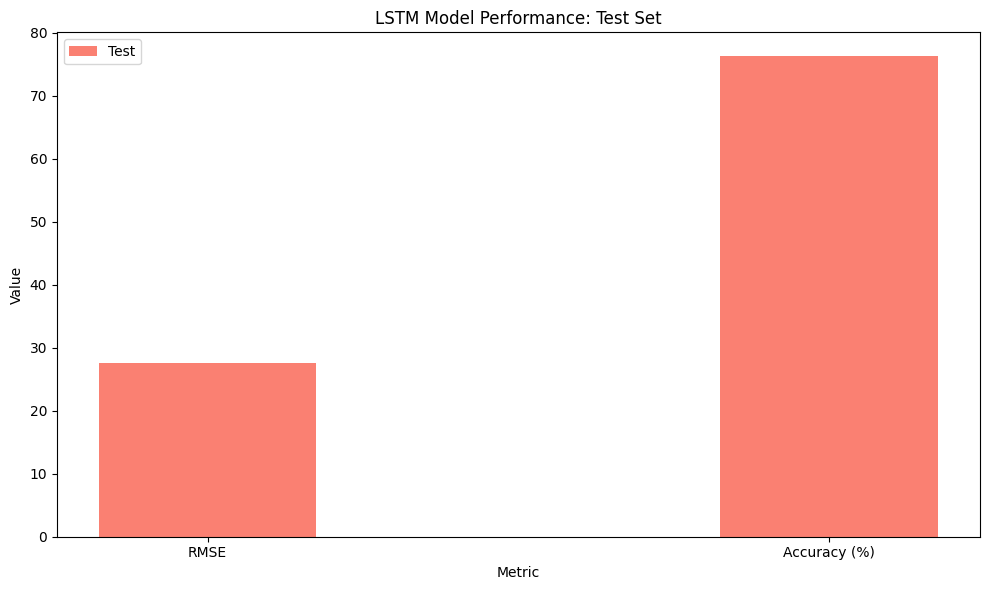

In [70]:
plt.figure(figsize=(10, 6))
metrics = ['RMSE', 'Accuracy (%)']
test_metrics = [rmse_test_lstm, accuracy_test_lstm]
x = np.arange(len(metrics))
width = 0.35

plt.bar(x, test_metrics, width, label='Test', color='salmon')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('LSTM Model Performance: Test Set')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

## XGBoost Model Training and Evaluation

In [71]:
# Prepare data for XGBoost
test_last = test_fd2.groupby('unit').last().reset_index()
test_last = test_last.merge(rul_fd2, on='unit')
y_test_xgb = test_last['rul']

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(train_fd2[train_idx][xgb_features], train_fd2[train_idx]['rul'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [72]:
# Evaluate XGBoost on validation set
y_pred_val_xgb = xgb_model.predict(val_data[xgb_features])
rmse_xgb_val = np.sqrt(mean_squared_error(val_data['rul'], y_pred_val_xgb))
print(f"XGBoost Validation RMSE: {rmse_xgb_val:.2f}")
# Approximate accuracy percentage based on max RUL (130)
accuracy_xgb_val = (1 - rmse_xgb_val / 130) * 100
print(f"XGBoost Validation Accuracy (%): {accuracy_xgb_val:.2f}")

# Evaluate XGBoost on test set
y_pred_test_xgb = xgb_model.predict(test_last[xgb_features])
rmse_xgb_test = np.sqrt(mean_squared_error(y_test_xgb, y_pred_test_xgb))
print(f"XGBoost Test RMSE: {rmse_xgb_test:.2f}")
# Approximate accuracy percentage based on max RUL (130)
accuracy_xgb_test = (1 - rmse_xgb_test / 130) * 100
print(f"XGBoost Test Accuracy (%): {accuracy_xgb_test:.2f}")

XGBoost Validation RMSE: 17.76
XGBoost Validation Accuracy (%): 86.33
XGBoost Test RMSE: 27.41
XGBoost Test Accuracy (%): 78.91


## Visualize XGBoost Results

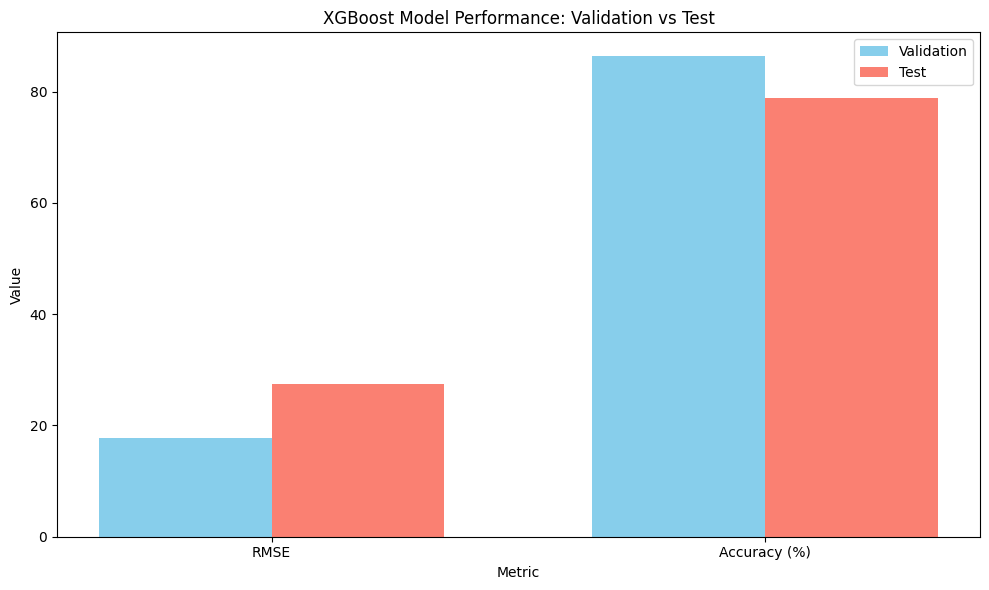

In [73]:
# Bar Chart for RMSE and Accuracy
plt.figure(figsize=(10, 6))
metrics = ['RMSE', 'Accuracy (%)']
val_metrics = [rmse_xgb_val, accuracy_xgb_val]
test_metrics = [rmse_xgb_test, accuracy_xgb_test]
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, val_metrics, width, label='Validation', color='skyblue')
plt.bar(x + width/2, test_metrics, width, label='Test', color='salmon')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('XGBoost Model Performance: Validation vs Test')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

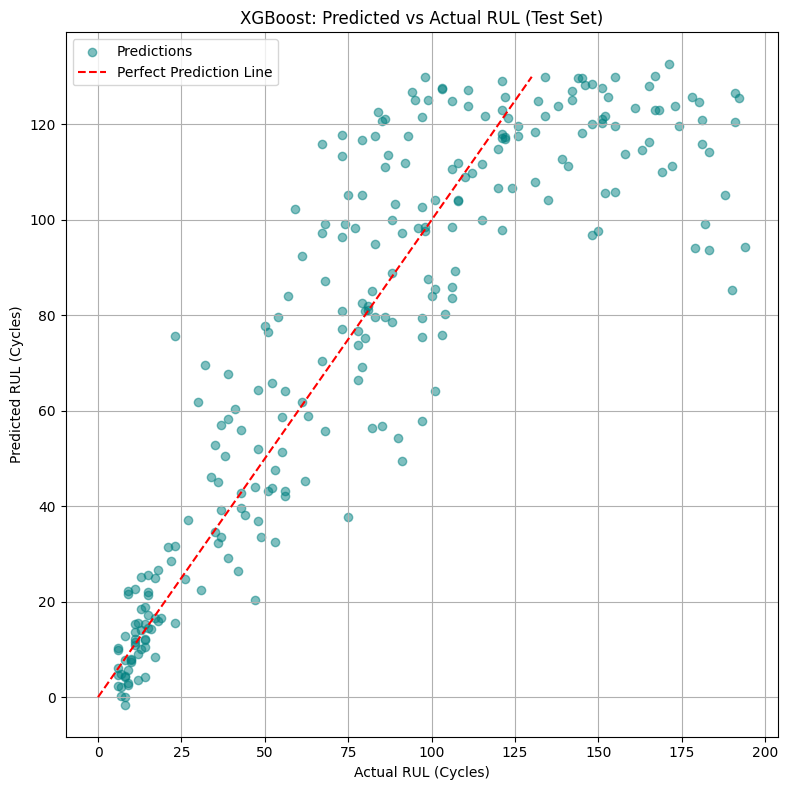

In [74]:
# Scatter Plot for Predicted vs Actual RUL (Test Set)
plt.figure(figsize=(8, 8))
plt.scatter(y_test_xgb, y_pred_test_xgb, alpha=0.5, color='teal', label='Predictions')
plt.plot([0, 130], [0, 130], 'r--', label='Perfect Prediction Line')
plt.xlabel('Actual RUL (Cycles)')
plt.ylabel('Predicted RUL (Cycles)')
plt.title('XGBoost: Predicted vs Actual RUL (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Comparison

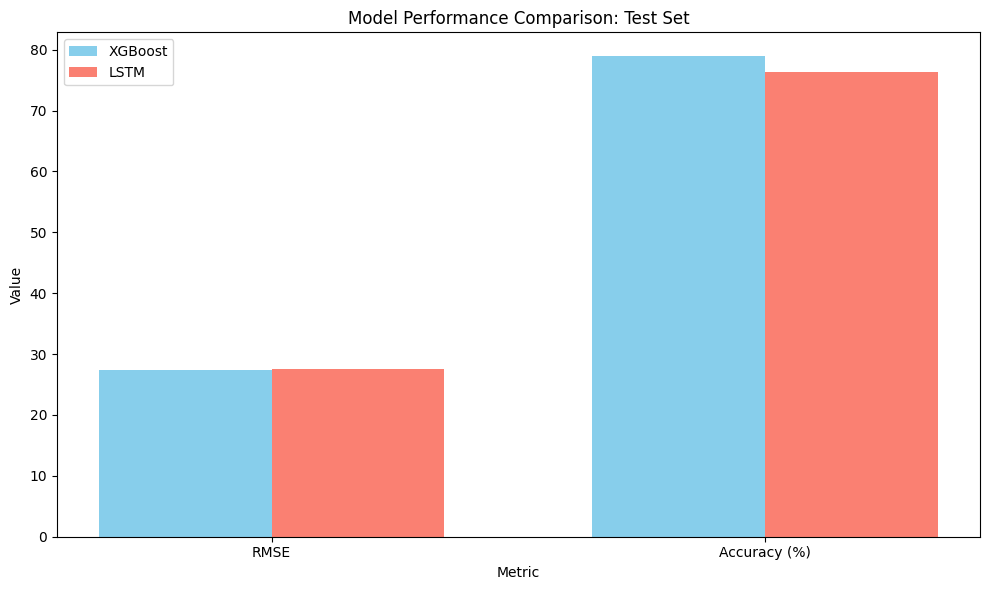

In [75]:
# Bar chart for RMSE and Accuracy
plt.figure(figsize=(10, 6))
metrics = ['RMSE', 'Accuracy (%)']
xgb_metrics = [rmse_xgb_test, accuracy_xgb_test]
lstm_metrics = [rmse_test_lstm, accuracy_test_lstm]
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, xgb_metrics, width, label='XGBoost', color='skyblue')
plt.bar(x + width/2, lstm_metrics, width, label='LSTM', color='salmon')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Model Performance Comparison: Test Set')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

## save model

In [77]:
lstm_model.save('FD002_model.keras')

## 3️⃣ Dataset - FD003

In [114]:
X_train_fd3.shape , y_train_fd3.shape , X_test_fd3.shape , y_test_fd3.shape

((24720, 19), (24720,), (100, 19), (259,))

In [115]:
# Convert DataFrames to NumPy arrays first
X_train_array = X_train_fd3.values  # or X_train.to_numpy()
X_test_array = X_test_fd3.values    # or X_test.to_numpy()

# Now reshape the arrays
X_train_3d = X_train_array.reshape((X_train_array.shape[0], 1, X_train_array.shape[1]))
X_test_3d = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))

print("X_train_3D shape:", X_train_3d.shape)
print("X_test_3D shape:", X_test_3d.shape)

X_train_3D shape: (24720, 1, 19)
X_test_3D shape: (100, 1, 19)


In [116]:
X_train_fd3.shape

(24720, 19)

In [125]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))


model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))


# Third LSTM Layer (last one without return_sequences)
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.1))

# Fully Connected Layers
model.add(Dense(64, activation='relu'))
model.add(Dense(1))   # Regression output (e.g., RUL prediction)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_3d, y_train_fd3,
    validation_data=(X_test_3d, y_test_fd3),
    epochs=100,
    batch_size=64,
    callbacks=[es]   #early stopping
)

Epoch 1/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 216.4605 - mae: 10.8376 - val_loss: 4430.9277 - val_mae: 55.2692
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.9687 - mae: 1.1189 - val_loss: 4423.2559 - val_mae: 55.1706
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.6523 - mae: 1.0247 - val_loss: 4445.0723 - val_mae: 55.3100
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.4877 - mae: 0.9697 - val_loss: 4475.8105 - val_mae: 55.5124
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.3037 - mae: 0.9083 - val_loss: 4469.6079 - val_mae: 55.4696
Epoch 6/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.1045 - mae: 0.8364 - val_loss: 4482.4297 - val_mae: 55.5543
Epoch 7/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9279 - mae: 0.7672 - val_loss: 4516.0220 - val_mae: 55.7768
Epoch 8/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.7798 - mae: 0.6939 - val_loss: 4486.2612 - val_mae: 55.5791
Epoch 9/100

## 4️⃣ Dataset - FD004

##  Prepare Data for Prime Time**

- Splitting data into training and testing sets.
- Standardizing the features to ensure all variables are on the same scale.

In [129]:
max_cycles_df = test_fd4.groupby('engine')['cycle'].max().reset_index()
max_cycles_df.columns = ['engine', 'max_cycles']
test_fd4 = pd.merge(test_fd4, max_cycles_df, on='engine', how='left')
test_fd4['RUL'] = test_fd4['max_cycles'] - test_fd4['cycle']
test_fd4.drop(columns=['max_cycles'], inplace=True)
RUL_fd4['engine']=RUL_fd4.index+1
RUL_fd4=RUL_fd4[['engine','RUL']]
rul_dict = RUL_fd4.set_index('engine')['RUL'].to_dict()
test_fd4['RUL'] = test_fd4['RUL'] + test_fd4['engine'].map(rul_dict)
test_fd4

engine  cycle  setting_1  setting_2  setting_3  \
0           1      1    20.0072     0.7000      100.0   
1           1      2    24.9984     0.6200       60.0   
2           1      3    42.0000     0.8420      100.0   
3           1      4    42.0035     0.8402      100.0   
4           1      5    35.0079     0.8400      100.0   
...       ...    ...        ...        ...        ...   
41209     248    277    41.9991     0.8401      100.0   
41210     248    278    20.0026     0.7005      100.0   
41211     248    279    34.9988     0.8413      100.0   
41212     248    280    20.0027     0.7000      100.0   
41213     248    281    35.0075     0.8402      100.0   

       (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                            491.19                         606.67   
1                            462.54                         536.22   
2                            445.00                         549.23   
3                            445.00                         549.19   
4                            449.44                         555.10   
...                             ...                            ...   
41209                        445.00                         550.30   
41210                        491.19                         608.00   
41211                        449.44                         555.92   
41212                        491.19                         608.19   
41213                        449.44                         556.40   

       (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                            1481.04                        1227.81   
1                            1256.17                        1031.48   
2                            1340.13                        1105.88   
3                            1339.70                        1107.26   
4                            1353.04                        1117.80   
...                              ...                            ...   
41209                        1364.40                        1129.17   
41210                        1494.75                        1260.88   
41211                        1370.65                        1130.97   
41212                        1489.11                        1256.25   
41213                        1378.58                        1140.70   

       (Fan inlet Pressure) (psia)  ...  (Corrected fan speed) (rpm)  \
0                             9.35  ...                      2387.78   
1                             7.05  ...                      2028.09   
2                             3.91  ...                      2387.95   
3                             3.91  ...                      2387.90   
4                             5.48  ...                      2387.87   
...                            ...  ...                          ...   
41209                         3.91  ...                      2388.50   
41210                         9.35  ...                      2388.33   
41211                         5.48  ...                      2388.64   
41212                         9.35  ...                      2388.37   
41213                         5.48  ...                      2388.59   

       (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  \
0                           8048.98           9.2229                     0.02   
1                           7863.46          10.8632                     0.02   
2                           8071.13           9.3960                     0.02   
3                           8078.89           9.3594                     0.02   
4                           8057.83           9.3030                     0.02   
...                             ...              ...                      ...   
41209                       8112.61           9.4427                     0.02   
41210                       8086.83           9.2772                     0.02   
41211                       8100.8

In [130]:
RUL_CLIP_VALUE = 125

train_fd4['RUL'] = train_fd4['RUL'].clip(upper=RUL_CLIP_VALUE)

print(f"RUL values have been clipped at a maximum of {RUL_CLIP_VALUE}.")
train_fd4

RUL values have been clipped at a maximum of 125.


engine  cycle  setting_1  setting_2  setting_3  \
0           1      1    42.0049     0.8400      100.0   
1           1      2    20.0020     0.7002      100.0   
2           1      3    42.0038     0.8409      100.0   
3           1      4    42.0000     0.8400      100.0   
4           1      5    25.0063     0.6207       60.0   
...       ...    ...        ...        ...        ...   
61244     249    251     9.9998     0.2500      100.0   
61245     249    252     0.0028     0.0015      100.0   
61246     249    253     0.0029     0.0000      100.0   
61247     249    254    35.0046     0.8400      100.0   
61248     249    255    42.0030     0.8400      100.0   

       (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  \
0                            445.00                         549.68   
1                            491.19                         606.07   
2                            445.00                         548.95   
3                            445.00                         548.70   
4                            462.54                         536.10   
...                             ...                            ...   
61244                        489.05                         605.33   
61245                        518.67                         643.42   
61246                        518.67                         643.68   
61247                        449.44                         555.77   
61248                        445.00                         549.85   

       (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  \
0                            1343.43                        1112.93   
1                            1477.61                        1237.50   
2                            1343.12                        1117.05   
3                            1341.24                        1118.03   
4                            1255.23                        1033.59   
...                              ...                            ...   
61244                        1516.36                        1315.28   
61245                        1598.92                        1426.77   
61246                        1607.72                        1430.56   
61247                        1381.29                        1148.18   
61248                        1369.75                        1147.45   

       (Fan inlet Pressure) (psia)  ...  (Corrected fan speed) (rpm)  \
0                             3.91  ...                      2387.99   
1                             9.35  ...                      2387.73   
2                             3.91  ...                      2387.97   
3                             3.91  ...                      2388.02   
4                             7.05  ...                      2028.08   
...                            ...  ...                          ...   
61244                        10.52  ...                      2388.73   
61245                        14.62  ...                      2388.46   
61246                        14.62  ...                      2388.48   
61247                         5.48  ...                      2388.83   
61248                         3.91  ...                      2388.66   

       (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  \
0                           8074.83           9.3335                     0.02   
1                           8046.13           9.1913                     0.02   
2                           8066.62           9.4007                     0.02   
3                           8076.05           9.3369                     0.02   
4                           7865.80          10.8366                     0.02   
...                             ...              ...                      ...   
61244                       8185.69           8.4541                     0.03   
61245                       8185.47           8.2221                     0.03   
61246                       8193.9

In [131]:
X = train_fd4.drop(columns=["engine", "cycle", "RUL"])
y = train_fd4["RUL"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler=StandardScaler()
X_train_s=scaler.fit_transform(X_train)
X_val_s=scaler.transform(X_val)

 Build and train multiple models:

   - XGBoost Regressor

   - Random Forest Regressor

   - LightGBM Regressor

   - LSTM

   - CatBoost Regressor

- Evaluated and compared model performance through detailed reports to identify the most suitable model for deployment and prediction. 

In [132]:
model_xgb = xgb.XGBRegressor(
    n_estimators=200,     
    max_depth=5,          
    learning_rate=0.1,    
    subsample=0.8,        
    colsample_bytree=0.8, 
    random_state=42
)

model_xgb.fit(X_train_s, y_train)

y_pred_xgb = model_xgb.predict(X_val_s)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
r2_xgb = r2_score(y_val, y_pred_xgb)

print(f"Validation RMSE: {rmse_xgb:.2f}")
print(f"Validation MAE: {mae_xgb:.2f}")
print(f"Validation R2 Score: {r2_xgb:.2f}")


Validation RMSE: 17.40
Validation MAE: 11.94
Validation R2 Score: 0.82


In [135]:
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=30,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_s, y_train)
y_pred_rf = rf_model.predict(X_val_s)
r2_rf= r2_score(y_val, y_pred_rf)

print("RF RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_rf)))
print("RF MAE:", mean_absolute_error(y_val, y_pred_rf))
print("RF R2:", r2_score(y_val, y_pred_rf))

RF RMSE: 17.264580627016787
RF MAE: 12.141144609773503
RF R2: 0.8198982289637791


In [137]:
lgb = LGBMRegressor(n_estimators=200, 
                    learning_rate=0.05,
                    num_leaves=31)  
lgb.fit(X_train_s, y_train)                  
y_pred_lgb = lgb.predict(X_val_s) 
r2_lgb= r2_score(y_val, y_pred_lgb)

print("LGBM RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_lgb)))
print("LGBM MAE:", mean_absolute_error(y_val, y_pred_lgb))
print(f"Validation R2 Score: {r2_lgb:.2f}")
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3813
[LightGBM] [Info] Number of data points in the train set: 48999, number of used features: 24
[LightGBM] [Info] Start training from score 92.882365
LGBM RMSE: 17.563654302525194
LGBM MAE: 12.102966819895368
Validation R2 Score: 0.81


In [138]:
X_train_seq = np.expand_dims(X_train_s, axis=1)
X_val_seq  = np.expand_dims(X_val_s, axis=1)

model_lstm = models.Sequential()
model_lstm.add(layers.Bidirectional(
    layers.LSTM(64, return_sequences=True),
    input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
))
model_lstm.add(layers.Dropout(0.3))
model_lstm.add(layers.LSTM(32))
model_lstm.add(layers.BatchNormalization())
model_lstm.add(layers.Dense(64, activation='relu'))
model_lstm.add(layers.Dense(1))

model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_lstm.fit(
    X_train_seq, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[callback],
    verbose=2
)

y_pred_lstm = model_lstm.predict(X_val_seq).reshape(-1)

print("LSTM RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_lstm)))
print("LSTM MAE:", mean_absolute_error(y_val, y_pred_lstm))
print("LSTM R2:", r2_score(y_val, y_pred_lstm))


Epoch 1/100
1225/1225 - 16s - 13ms/step - loss: 2867.8469 - val_loss: 655.6118
Epoch 2/100
1225/1225 - 6s - 5ms/step - loss: 924.2079 - val_loss: 594.9764
Epoch 3/100
1225/1225 - 6s - 5ms/step - loss: 824.1564 - val_loss: 497.0837
Epoch 4/100
1225/1225 - 6s - 5ms/step - loss: 768.4672 - val_loss: 470.7802
Epoch 5/100
1225/1225 - 6s - 5ms/step - loss: 723.9188 - val_loss: 572.7505
Epoch 6/100
1225/1225 - 6s - 5ms/step - loss: 665.5543 - val_loss: 471.5957
Epoch 7/100
1225/1225 - 6s - 5ms/step - loss: 614.1779 - val_loss: 446.6018
Epoch 8/100
1225/1225 - 6s - 5ms/step - loss: 565.1160 - val_loss: 475.7165
Epoch 9/100
1225/1225 - 6s - 5ms/step - loss: 517.0878 - val_loss: 425.0612
Epoch 10/100
1225/1225 - 6s - 5ms/step - loss: 491.9278 - val_loss: 428.5052
Epoch 11/100
1225/1225 - 6s - 5ms/step - loss: 478.1326 - val_loss: 434.2393
Epoch 12/100
1225/1225 - 6s - 5ms/step - loss: 473.5129 - val_loss: 421.0767
Epoch 13/100
1225/1225 - 6s - 5ms/step - loss: 464.1903 - val_loss: 445.4917
Epoch

In [139]:
model_cb = CatBoostRegressor(loss_function='RMSE')
model_cb.fit(X_train_s, y_train, verbose=100)
y_pred_cb = model_cb.predict(X_val_s)
r2_cb= r2_score(y_val, y_pred_cb)

print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_cb)))
print("CatBoost MAE:", mean_absolute_error(y_val, y_pred_cb))
print(f"Validation R2 Score: {r2_cb:.2f}")

Learning rate set to 0.075723
0:	learn: 38.9228067	total: 62.7ms	remaining: 1m 2s
100:	learn: 18.8059956	total: 781ms	remaining: 6.95s
200:	learn: 17.7289801	total: 1.5s	remaining: 5.94s
300:	learn: 17.2189944	total: 2.2s	remaining: 5.11s
400:	learn: 16.8707843	total: 2.91s	remaining: 4.35s
500:	learn: 16.6033289	total: 3.62s	remaining: 3.6s
600:	learn: 16.3805212	total: 4.32s	remaining: 2.87s
700:	learn: 16.1722130	total: 5.02s	remaining: 2.14s
800:	learn: 15.9863121	total: 5.73s	remaining: 1.42s
900:	learn: 15.8111833	total: 6.43s	remaining: 707ms
999:	learn: 15.6518125	total: 7.13s	remaining: 0us
CatBoost RMSE: 17.190783461089676
CatBoost MAE: 11.733080863828851
Validation R2 Score: 0.82


In [140]:
final_comparison_data = {
    'Metric': ['RMSE', 'MEA', 'R-squared'],
    'XGBRegressor': [rmse_xgb ,mae_xgb ,r2_xgb],
    'Random forest': [np.sqrt(mean_squared_error(y_val, y_pred_rf)), mean_absolute_error(y_val, y_pred_rf), r2_rf],
    'LGBMRegressor':[np.sqrt(mean_squared_error(y_val, y_pred_lgb)), mean_absolute_error(y_val, y_pred_lgb), r2_lgb],
    'LSTM': [np.sqrt(mean_squared_error(y_val, y_pred_lstm)),mean_absolute_error(y_val, y_pred_lstm),r2_score(y_val, y_pred_lstm)],  
    'CatBoost': [np.sqrt(mean_squared_error(y_val, y_pred_cb)),mean_absolute_error(y_val, y_pred_cb),r2_cb]
}

final_comparison_df = pd.DataFrame(final_comparison_data)

final_comparison_df.set_index('Metric', inplace=True)

print("Final Performance Comparison on the Test Set:")
display(final_comparison_df.round(2))


Final Performance Comparison on the Test Set:


XGBRegressor  Random forest  LGBMRegressor   LSTM  CatBoost
Metric                                                                
RMSE              17.40          17.26          17.56  19.37     17.19
MEA               11.94          12.14          12.10  13.69     11.73
R-squared          0.82           0.82           0.81   0.77      0.82

In [141]:
def regression_report(model, X_train, y_train, X_val, y_val, name="Model"):

    y_pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)

    y_pred_val = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    r2_val = r2_score(y_val, y_pred_val)

    report = pd.DataFrame({
        "Dataset": ["Train", "Validation"],
        "RMSE": [rmse_train, rmse_val],
        "MAE": [mae_train, mae_val],
        "R2": [r2_train, r2_val]
    })
    print(f"\n{name} Report:\n", report)
    return report


regression_report(model_xgb, X_train_s, y_train, X_val_s, y_val, "XGBoost")
regression_report(rf_model, X_train_s, y_train, X_val_s, y_val, "RandomForest")
regression_report(lgb, X_train_s, y_train, X_val_s, y_val, "LightGBM")
regression_report(model_cb, X_train_s, y_train, X_val_s, y_val, "CatBoost")


y_pred_train_lstm = model_lstm.predict(X_train_seq).reshape(-1)
y_pred_val_lstm = model_lstm.predict(X_val_seq).reshape(-1)

report_lstm = pd.DataFrame({
    "Dataset": ["Train", "Validation"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_train, y_pred_train_lstm)),
        np.sqrt(mean_squared_error(y_val, y_pred_val_lstm))
    ],
    "MAE": [
        mean_absolute_error(y_train, y_pred_train_lstm),
        mean_absolute_error(y_val, y_pred_val_lstm)
    ],
    "R2": [
        r2_score(y_train, y_pred_train_lstm),
        r2_score(y_val, y_pred_val_lstm)
    ]
})

print("\nLSTM Report:\n", report_lstm)


XGBoost Report:
       Dataset       RMSE        MAE        R2
0       Train  16.213417  11.118091  0.840993
1  Validation  17.404254  11.938466  0.816972

RandomForest Report:
       Dataset       RMSE        MAE        R2
0       Train   6.576749   4.608954  0.973837
1  Validation  17.264581  12.141145  0.819898

LightGBM Report:
       Dataset       RMSE        MAE        R2
0       Train  16.691773  11.495601  0.831472
1  Validation  17.563654  12.102967  0.813604

CatBoost Report:
       Dataset       RMSE        MAE        R2
0       Train  15.651813  10.675042  0.851818
1  Validation  17.190783  11.733081  0.821435
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

LSTM Report:
       Dataset       RMSE        MAE        R2
0       Train  19.575451  13.746658  0.768213
1  Validation  19.370931  13.685578  0.773271


In [142]:
test_fd4.iloc[41209]

engine                                      248.0000
cycle                                       277.0000
setting_1                                    41.9991
setting_2                                     0.8401
setting_3                                   100.0000
(Fan inlet temperature) (◦R)                445.0000
(LPC outlet temperature) (◦R)               550.3000
(HPC outlet temperature) (◦R)              1364.4000
(LPT outlet temperature) (◦R)              1129.1700
(Fan inlet Pressure) (psia)                   3.9100
(bypass-duct pressure) (psia)                 5.7200
(HPC outlet pressure) (psia)                138.3400
(Physical fan speed) (rpm)                 2212.3500
(Physical core speed) (rpm)                8351.7300
(Engine pressure ratio(P50/P2)                1.0200
(HPC outlet Static pressure) (psia)          42.3000
(Ratio of fuel flow to Ps30) (pps/psia)     130.8700
(Corrected fan speed) (rpm)                2388.5000
(Corrected core speed) (rpm)               811

In [143]:
new_sensor_reading = {
"setting_1":41.9991,
"setting_2":0.8401,
"setting_3":100.0000,
"(Fan inlet temperature) (◦R)":445.0000,
"(LPC outlet temperature) (◦R)" :550.3000,
"(HPC outlet temperature) (◦R)":1364.4000,
"(LPT outlet temperature) (◦R)":1129.1700,
"(Fan inlet Pressure) (psia)":3.9100,
"(bypass-duct pressure) (psia)":5.7200,
"(HPC outlet pressure) (psia)":138.3400,
"(Physical fan speed) (rpm)":2212.3500,
"(Physical core speed) (rpm)":8351.7300,
"(Engine pressure ratio(P50/P2)":1.0200,
"(HPC outlet Static pressure) (psia)":42.3000,
"(Ratio of fuel flow to Ps30) (pps/psia)":130.8700,
"(Corrected fan speed) (rpm)":2388.5000,
"(Corrected core speed) (rpm)":8112.6100,
"(Bypass Ratio) ":9.4427,
"(Burner fuel-air ratio)":0.0200,
"(Bleed Enthalpy)":331.0000,
"(Required fan speed)":2212.0000,
"(Required fan conversion speed)":100.0000,
"(High-pressure turbines Cool air flow)":10.5300,
"(Low-pressure turbines Cool air flow)":6.2620
    # RUL = 30 
}

sensor_data = pd.DataFrame([new_sensor_reading])
sensor_data = sensor_data[X_train.columns]
sensor_data = scaler.transform(sensor_data)
sensor_data_df= pd.DataFrame(sensor_data, columns=X_train.columns)

rul_pred = model_cb.predict(sensor_data_df)

print(f"Predicted RUL: {int(rul_pred[0])}")

Predicted RUL: 32


In [ ]:
model_cb.save_model("FD004_model.cbm")